In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from astropy.io import fits
import corner
from matplotlib import rcParams
import os
import math
from scipy import optimize
from scipy import stats
import time
import random
import tqdm
import read_mist_models
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
from arviz import plot_trace as traceplot
rcParams["figure.figsize"] = (14.4, 8.1)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"]})
rcParams["font.size"] = 14.0

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [177]:
def subtract(n):
    
    '''Function that takes in a sum of bitmask digits and returns another bitmask digit.
    Function is meant to be run iteratively to determine all of the digits in the sum.
    
    Input:
    n: input digit
    
    Output:
    list: a list of a new digit and a flag telling which digit was in the sum.'''
    
    if n-1 <= 0:
        
        return [n-1, 0]
    
    elif n-2 <= 0:
        
        return [n-1, 1]
    
    elif n-4 <= 0:
        
        return [n-2, 2]
    
    elif n-8 <= 0:
        
        return [n-4, 3]
    
    elif n-16 <= 0:
        
        return [n-8, 4]
    
    elif n-32 <= 0:
        
        return [n-16, 5]
    
    elif n-64 <= 0:
        
        return [n-32, 6]
    
    elif n-128 <= 0:
        
        return [n-64, 7]
    
    elif n-256 <= 0:
        
        if n-256 == 0:
            
            return [0, 8]
        
        else:
            
            return [n-128, 8]
    
    elif n-512 <= 0:
        
        if n-512 == 0:
            
            return [0, 9]
        
        else:
            
            return [n-256, 9]
    
    elif n-1024 <= 0:
        
        if n-1024 == 0:
            
            return [0, 10]
        
        else:
            
            return [n-512, 10]
    
    elif n-2048 <= 0:
        
        if n-2048 == 0:
            
            return [0, 11]
        
        else:
        
            return [n-1024, 11]
    
    elif n-4096 <= 0:
        
        return [n-2048, 12]
    
    elif n-8192 <= 0:
        
        if n-8192 == 0:
            
            return [0, 13]
        
        else:
        
            return [n-4096, 13]
    
    elif n-16384 <= 0:
        
        if n-16384 == 0:
            
            return [0, 14]
        
        else:
        
            return [n-8192, 14]
    
    else:
        
        return [n-16384, 15]
    
def pixel_checker(err_arr, mask_arr):
    
    '''Function that takes in an error array and a bitmask array to determine
    which errors need to be altered based upon the bitmasks. Function does so by iteratively
    calling subtract(n).
    
    Intput:
    err_arr: list of errors
    masak_arr: list of bitmasks
    
    Output:
    err_arr: updated list of new errors'''
    
    err_copy = []
    
    for val in err_arr:
        
        err_copy.append(val)
    
    for i, n in zip(range(len(err_arr)), mask_arr):
    
        while n != 0:

            tup = subtract(n)
            n = tup[0]

            if tup[1] == 0 or tup[1] == 1 or tup[1] == 2 or tup[1] == 3 or\
               tup[1] == 4 or tup[1] == 5 or tup[1] == 6 or tup[1] == 7 or tup[1] == 12:

                err_copy[i] = 10**10
                break
                
    return err_copy

In [178]:
def sturdy_spectra(cont_wls, wls):
    
    '''Function that takes in continuum wavelengths and wavelengths obtained from
    .fits files and then determines which wavelengths in the .fits are closest to
    the continuum wavelengths.
    
    Input:
    cont_wls: list of wavelengths which are continuum wavelengths
    wls: list of wavelengths
    
    Output:
    list of indices denoting which .fits file wavelengths are closest to continuum
    wavelengths'''
    
    wls = np.array(wls)
    
    ind_list = []
    
    beg_ind = 0
    end_ind = len(wls)

    i = 0
    j = 0

    while beg_ind != end_ind and i != len(cont_wls):

        temp = wls[beg_ind:end_ind]

        for c_wl in cont_wls:
            
            i+=1
            
            for wl in temp:

                if abs(wl-c_wl) < 0.3:
                    
                    ind_list.append(np.where(wls == wl)[0][0])
                    
                else:

                    beg_ind+=1
                
    return np.array(ind_list)

In [179]:
def normed_spectra(cont_wls, cont_spectrum, cont_errs, spectrum, errors, wls):
    
    '''Function that takes in .fits wavelengths, spectra, and errors which are determined to be
    continuum wavelengths, spectra, and errors along with the full wavelength, spectra, and errors
    to perform a continuum normalization process by using a second degree Chebyshev interpolation
    polynomial on the determined continuum pixels.
    
    Input:
    cont_wls: continuum wavelengths from the .fits files
    cont_spectrum: continuum spectrum from the .fits files
    cont_errs: continuum errors from the .fits files
    spectrum: full spectrum list from the .fits files
    errors: full errors list from the .fits files
    wls: full wavelengths list from the .fits files
    
    Output:
    norm_spec: continuum normalized spectrum
    norm_err: continuum normalized errors'''

    cheby_coeffs = np.polynomial.chebyshev.Chebyshev.fit(cont_wls, cont_spectrum, 2,\
                                                         window=[wls[0], wls[-1]], w=1/cont_errs)

    norm_spec = []
    norm_err = []
    
    for i in range(len(spectrum)):
        
        norm_factor = np.polynomial.chebyshev.chebval(wls[i], cheby_coeffs.coef)
        norm_spec.append(spectrum[i]/norm_factor)
        norm_err.append(errors[i]/norm_factor)

    return [norm_spec, norm_err]

In [180]:
def spectrum_optimize(X, flux_vec, errs_vec, s_grid):
    
    '''Function that takes in a matrix of stellar labels for N stars, a flux vector of fluxes from N
    stars at a given pixel, an errors vector from N stars at a given pixel, and an interval of possible
    s^2 values. The function then uses these values to perform a WLS to determine fit parameters based
    the known labels and spectra to formulate parameters for a quadratic-in-labels model. Then, the
    function steps through this interval by calculating the log-likelihood at 5 points and creates a new
    interval centered about the area with the highest value and repeats until either the interval shrinks
    to below 0.01 length or the probability between the endpoints falls below a certain value.
    
    Input:
    X: matrix of stellar labels
    flux_vec: vector of fluxes at a pixel for N stars
    errs_vec: vector of errors at a pixel for N stars
    s_grid: interval of possible s^2 values for the log-likelihood function
    
    Output:
    list of parameters:
        theta: fit parameters for a quadratic-in-labels model
        s^2: intrinsic scatter that captures our models simplicity and the actual dependence
        upon other labels we do not use'''
    
    W = 1/np.array(errs_vec)
    Xw = X * W[:,np.newaxis]
    Fw = flux_vec * W
   
    theta = np.linalg.lstsq(Xw, Fw)[0]
    thetaT = np.matrix.transpose(theta)
    
    a = s_grid[0]
    b = s_grid[1]
    h = (b-a)/2
    a_h = a+h/2
    b_h = b-h/2
    prob_a = 0
    prob_b = 101
    prob_h = 0
    prob_a_h = 0
    prob_b_h = 0
    a_ct = 0
    b_ct = 0
    ct=0
    
    while abs(prob_b-prob_a) > 50 and abs(b-a) > 0.01:
            
        if prob_a == 0 and prob_b == 101:
            
            prob_b = 0
                
            for j in range(len(X)):
                
                fluxj = flux_vec[j]
                Xj = X[j]
                errsj = errs_vec[j]
                
                prob_a = prob_a-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(a+errsj**2)\
                    -0.5*np.log(a+errsj**2)
                prob_b = prob_b-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(b+errsj**2)\
                        -0.5*np.log(b+errsj**2)
                prob_h = prob_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(a+h+errsj**2)\
                        -0.5*np.log(a+h+errsj**2)
                prob_a_h = prob_a_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(a_h+errsj**2)\
                    -0.5*np.log(a_h+errsj**2)
                prob_b_h = prob_b_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(b_h+errsj**2)\
                    -0.5*np.log(b_h+errsj**2)
                    
        else:

            for j in range(len(X)):
                
                fluxj = flux_vec[j]
                Xj = X[j]
                errsj = errs_vec[j]

                prob_h = prob_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(h+errsj**2)\
                        -0.5*np.log(h+errsj**2)
                prob_a_h = prob_a_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(a_h+errsj**2)\
                    -0.5*np.log(a_h+errsj**2)
                prob_b_h = prob_b_h-0.5*(fluxj-np.matmul(thetaT, Xj))**2/(b_h+errsj**2)\
                    -0.5*np.log(b_h+errsj**2)

        max_val = max([prob_a, prob_b, prob_h, prob_a_h, prob_b_h])

        if max_val == prob_a or max_val == prob_a_h:
            
            b=a+(b-a)/2
            prob_b = prob_h
            a_ct+=1
            b_ct=0
            
        if max_val == prob_b or max_val == prob_b_h:
            
            a=a+(b-a)/2
            prob_a = prob_h
            a_ct+=1
            b_ct=0
            
        if max_val == prob_h:
            
            a=a+(b-a)/4
            b=b-(b-a)/4
            a_ct+=1
            b_ct+=1
            
        if a_ct>10 and b_ct<10:
            
            b=a
            a=0
            prob_a=0
            prob_b=0
            
        if b_ct>10 and a_ct<10:
            
            a=b
            b=1
            prob_a=0
            prob_b=0
        
        h=(b-a)/2
        a_h = a+h/2
        b_h = b-h/2
        
        prob_h = 0
        prob_a_h = 0
        prob_b_h = 0
    
    return [theta, a+(b-a)/2]

In [181]:
def model(theta_arr, teff, logg, fe_h, mg_fe, si_fe):
    
    '''Function that takes in a matrix of fit parameters obtained from spectrum_optimize and
    5 stellar labels and calculates what the spectrum should be based upon a quadratic-in-labels
    model
    
    Input:
    theta_arr: matrix of theta values obtained by performing a WLS
    teff: effective temperature parameter
    logg: log(g) parameter
    fe_h: concentration [Fe/H]
    mg_fe: concentration [Mg/Fe]
    si_fe: concentration [Si/Fe]
    
    Output:
    spectrum calculated from a matrix multiplication between the labels vector and the
    theta matrix'''
    
    ell = np.array([1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h,
                    teff*mg_fe, teff*si_fe,logg**2,logg*fe_h, logg*mg_fe, logg*si_fe,
                    fe_h**2, fe_h*mg_fe, fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2])
    
    spectrum = np.matmul(theta_arr, ell)
    
    return spectrum

In [182]:
def my_logllh(theta_arr, params, data, sigma):
    
    '''
    log-likelihood function that takes in thetas obtained from spectrum_optimize,
    parameters which are stellar labels, observed spectra, and sigma which is the uncertainties
    
    Input:
    theta_arr: matrix of theta values
    params: teff, logg, fe_h, mg_fe, si_fe
    data: observed spectrum data
    sigma: sqrt(s^2+errors^2)
    '''
    
    teff=params[0]
    logg=params[1]
    fe_h=params[2]
    mg_fe=params[3]
    si_fe=params[4]
    
    model_vals = model(theta_arr, teff, logg, fe_h, mg_fe, si_fe)
    
    return np.sum(-(0.5/sigma**2)*((data - model_vals)**2)-0.5*np.log(sigma**2))

In [183]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (params,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.x, params, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

# Obtaining data

First, we must perform rsync queries to the SDSS database to obtain .fits files to perform our analyses upon. These files contain most of the necessary data, but we are using them primarily to obtain the spectra of individual stars within fields defined by APOGEE. For our analysis, we have restricted our attention to the 060+00, M15, K2_C4_168-21, and N6791 fields which yields us 3036 .fits files altogether.

In [184]:
sync_bool=False

if sync_bool:    
    
    !rsync -r -a \
        --include "apStar-*.fits" --exclude "*" \
        --prune-empty-dirs --progress \
        --ignore-existing \
        rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/ fits_files

    !rsync -r -a \
        --include "apStar-*.fits" --exclude "*" \
        --prune-empty-dirs --progress \
        --ignore-existing \
        rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/ fits_files

    !rsync -r -a \
        --include "apStar-*.fits" --exclude "*" \
        --prune-empty-dirs --progress \
        --ignore-existing \
        rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/ fits_files

    !rsync -r -a \
        --include "apStar-*.fits" --exclude "*" \
        --prune-empty-dirs --progress \
        --ignore-existing \
        rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/ fits_files

# Coadded spectra & frame of reference

We will find that each file contains a different number of visits. The multiple visits allow us to gather a sort of average spectra of the star since one spectra only gives us one still frame in time whereas multiple visits allows us to look at the star at different points in time. We need these coadded spectra to be Doppler shifted to the Barycentric frame because each visit has a different position and velocity relative to a chosen reference point and so to ensure that we have measured the flux at the correct wavelength, we must use one reference frame for all visits.

# The units -- what do they mean?

Below, we can see an example spectra obtained from one of the .fits files that we obtained from the APOGEE server. The fluxes are given in $10^{-17} \textrm{erg}/\textrm{s}/\textrm{cm}^2/\textrm{Ang}$. Intuitively, we can understand these units as $\textrm{energy}/\textrm{time}\times1/(\textrm{area}\times\textrm{wavelength}) = \textrm{intensity}/\textrm{wavelength}$. Thus, the units are units of spectral intensity or radiant flux per unit wavelength.

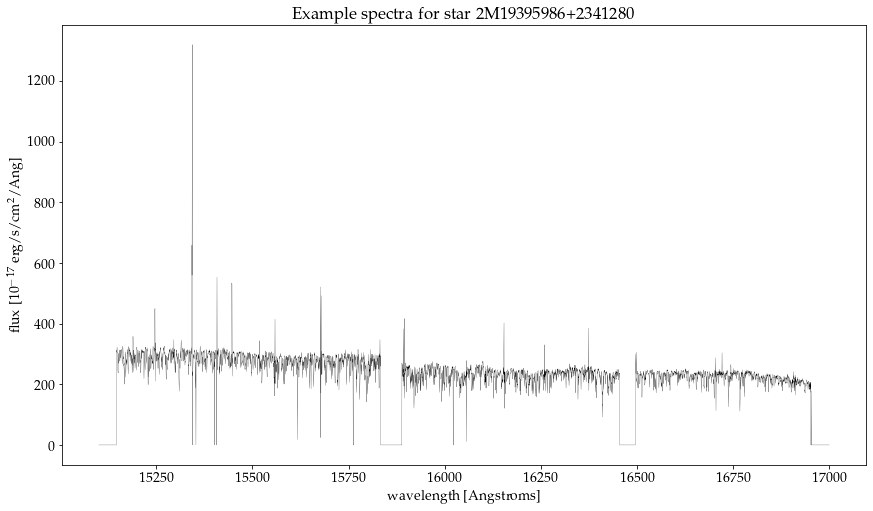

(-10.0, 30.0)

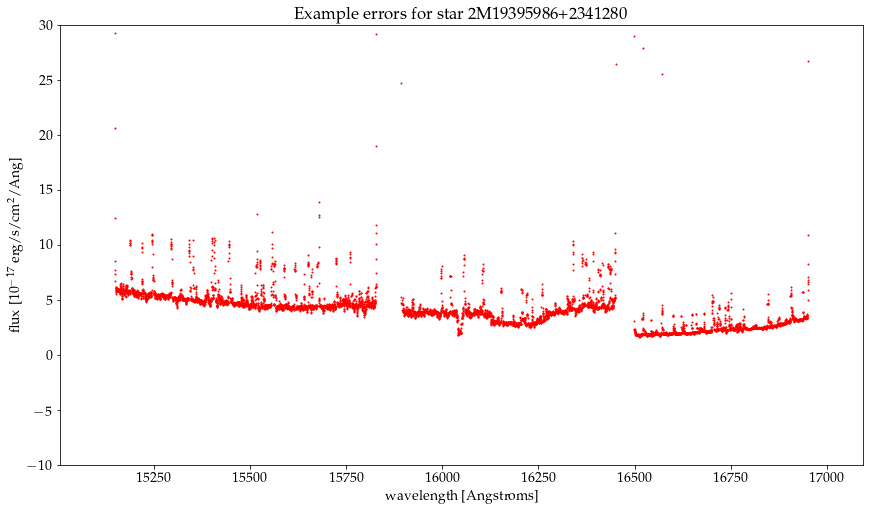

In [185]:
from matplotlib import rc
rc("text", usetex=True)
hdul = fits.open('fits_files/apStar-r12-2M19395986+2341280.fits')

wavelength = np.linspace(10**(hdul[0].header['crval1']),
                         10**(hdul[0].header['crval1']+8575*hdul[0].header['cdelt1']),8575)

plt.plot(wavelength, hdul[1].data[0], linewidth=0.2, color='k')
plt.xlabel('wavelength [Angstroms]')
plt.ylabel('flux [$10^{-17}$ erg/s/cm$^2$/Ang]')
plt.title(f'Example spectra for star {hdul[0].header["objid"]}')
plt.show()

plt.scatter(wavelength, hdul[2].data[0], s=1.0, color='r')
plt.xlabel('wavelength [Angstroms]')
plt.ylabel('flux [$10^{-17}$ erg/s/cm$^2$/Ang]')
plt.title(f'Example errors for star {hdul[0].header["objid"]}')
plt.ylim(-10, 30)

# Stellar Physics primer

By performing the cuts to obtain our training set we have excluded dwarf stars from our set. White dwarfs are compact objects and so they have extremely high densities. Since
$$
\vec{g} = -\frac{Gm}{r^2}\hat{r},
$$
where
$$
m = \int_{V} \rho(x, y, z)dV,
$$
we can see that as $\rho$ increases in value that $\vec{g}$ will increase in value as well. Thus, we exclude any dwarf stars as opposed to giant stars which have much lower densities and therefore lower gravity values at the surface.

For a star on the main sequence with radius of $c R_{\odot}$, we see that
$$
g = \frac{GM_{\odot}}{c R_{\odot}^2}.
$$
At $c=1$, we get $275.1 \textrm{m}/\textrm{s}^2$. At $c=100$, we get $0.02751 \textrm{m}/\textrm{s}^2$. At $c=15$, we get $1.2227 \textrm{m}/\textrm{s}^2$.

# Which stars are we after?

This code opens the various .fits files and the allStar .fits file and allows us to whittle down our dataset into one that we desire to perform our analysis. Specifically, we want giant stars. So, we want lower effective temperatures $3000 < T_{\text{eff}} < 6000$ to eliminate the bright stars, $\log{(\text{g})} 0 < \log{(\text{g})} < 4$ to eliminate dwarf stars and compact objects, and lower metallicity $\text{[Fe/H]:} -1 < \text{[Fe/H]} < 0$. Additionally, we want higher SNR so that we have good fluxes to use in training our model so that our label predictions are more accurate.

In [186]:
allStar = fits.open('allStar-r12-l33.fits')

corner_teff = []
corner_logg = []
corner_fe_h = []
corner_mg_fe = []
corner_si_fe = []
labels_arr = []
allStar_list = []

for i in tqdm.tqdm(range(len(allStar[1].data))):
    
    labels = {}
    
    if allStar[1].data[i][7] == '060+00' or allStar[1].data[i][7] == 'M15' or allStar[1].data[i][7] == 'N6791' or \
       allStar[1].data[i][7] == 'K2_C4_168-21':
        
        if 0 < allStar[1].data[i][75] < 5700 and 0 < allStar[1].data[i][77] < 4 and -1 < allStar[1].data[i][114] and \
           -9998 < allStar[1].data[i][102] and -9998 < allStar[1].data[i][104] and allStar[1].data[i][31] > 50:
            
            hdul = fits.open(f'fits_files/apStar-r12-{allStar[1].data[i][4]}.fits')
            
            if isinstance(hdul[1].data[0], np.ndarray):

                corner_teff.append(allStar[1].data[i][75])
                corner_logg.append(allStar[1].data[i][77])
                corner_fe_h.append(allStar[1].data[i][114])
                corner_mg_fe.append(allStar[1].data[i][102])
                corner_si_fe.append(allStar[1].data[i][104])

                labels['spectrum'] = hdul[1].data[0]
                labels['errors'] = hdul[2].data[0]
                labels['bitmask'] = hdul[3].data[0]
                labels['filename'] = allStar[1].data[i][4]
                labels['snr'] = allStar[1].data[i][31]
                labels['teff'] = allStar[1].data[i][75]
                labels['logg'] = allStar[1].data[i][77]
                labels['fe_h'] = allStar[1].data[i][114]
                labels['mg_fe'] = allStar[1].data[i][102]
                labels['si_fe'] = allStar[1].data[i][104]
                labels['allStar_misc'] = allStar[1].data[i]
                

                labels_arr.append(labels)     

100%|██████████| 473307/473307 [00:55<00:00, 8565.70it/s] 


# Label Distributions

We can see below that we have a good cluster of stars with myriad combinations of labels despite the fact that a majority have temperatures that are between $4250-5000$K, $\log{(\text{g})}$ between $2.0-3.2$, and metallicities between $-0.2-0.2$. This distribution allows us to train our model so that for any stars with a combination of labels in the total ranges we may be able to estimate the labels within a reasonable error.

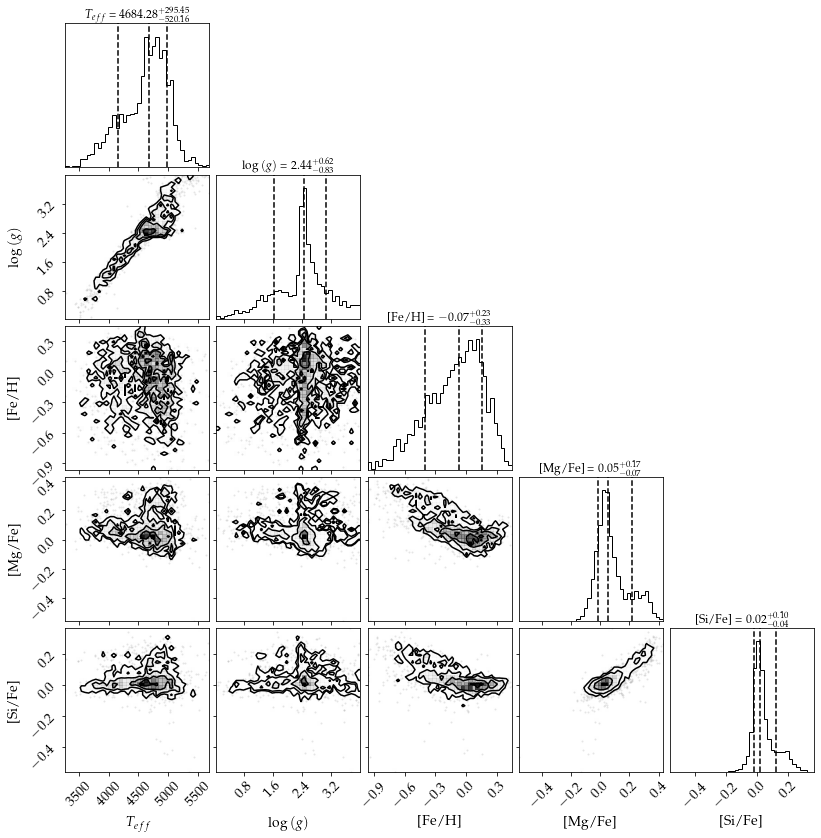

In [187]:
vstack_arr = np.vstack([corner_teff, corner_logg, corner_fe_h, corner_mg_fe, corner_si_fe])

figure = corner.corner(vstack_arr.T, labels=[r"$T_{eff}$", r"$\log{(g)}$", r"[Fe/H]", r"[Mg/Fe]", r"[Si/Fe]"],bins=40,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

# Continuum pixels

Below, we use the .npz file given to us which contains two lists: one list is a list of wavelengths and the other list is a list of flags which tell us whether or not the wavelength at the same index is a continuum wavelength or not. Continuum wavelengths are those wavelengths which are particularly sturdy with regards to changes in the various labels thus making them good candidates for determining the true underlying behavior regarding a spectra and what its ideal blackbody curve would look like.

In [188]:
continuum_pixels = np.load('continuum_pixels_apogee.npz')

In [189]:
pcont_wls = continuum_pixels['wavelength']
cont_wls = continuum_pixels['wavelength'][np.where(continuum_pixels['is_continuum'] == True)]

In [190]:
'''
Initialized lists to contain the data of the three separate chips
'''

wl_l = []
spec_l = []
cont_wl_l = []
pcont_wl_l = []
errs_l = []
cont_errs_l = []

wl_m = []
spec_m = []
cont_wl_m = []
pcont_wl_m = []
errs_m = []
cont_errs_m = []

wl_h = []
spec_h = []
cont_wl_h = []
pcont_wl_h = []
errs_h = []
cont_errs_h = []

'''
Code that loops through the original wavelength, spectrum, and errors lists to obtain
data to be normalized and corrected
'''

tqdm.tqdm._instances.clear()
for i in tqdm.tqdm(range(len(wavelength))):
    
    if 15150 < wavelength[i] < 15800:
        
        wl_l.append(wavelength[i])
        spec_l.append(hdul[1].data[0][i])
        errs_l.append(hdul[2].data[0][i])
        
    if 15890 < wavelength[i] < 16430:
        
        wl_m.append(wavelength[i])
        spec_m.append(hdul[1].data[0][i])
        errs_m.append(hdul[2].data[0][i])
        
    if 16490 < wavelength[i] < 16950:
        
        wl_h.append(wavelength[i])
        spec_h.append(hdul[1].data[0][i])
        errs_h.append(hdul[1].data[0][i])
        
for i in range(len(pcont_wls)):
    
    if 15150 < pcont_wls[i] < 15800:
        
        pcont_wl_l.append(pcont_wls[i])
        
        if continuum_pixels['is_continuum'][i] == True:
            
            cont_wl_l.append(pcont_wls[i])
        
    if 15890 < pcont_wls[i] < 16430:
        
        pcont_wl_m.append(pcont_wls[i])
        
        if continuum_pixels['is_continuum'][i] == True:
            
            cont_wl_m.append(pcont_wls[i])
        
    if 16490 < pcont_wls[i] < 16950:
        
        pcont_wl_h.append(pcont_wls[i])
        
        if continuum_pixels['is_continuum'][i] == True:
            
            cont_wl_h.append(pcont_wls[i])
            
wl_l = np.array(wl_l)
spec_l = np.array(spec_l)
cont_wl_l = np.array(cont_wl_l)
pcont_wl_l = np.array(pcont_wl_l)
errs_l = np.array(errs_l)

wl_m = np.array(wl_m)
spec_m = np.array(spec_m)
cont_wl_m = np.array(cont_wl_m)
pcont_wl_m = np.array(pcont_wl_m)
errs_m = np.array(errs_m)

wl_h = np.array(wl_h)
spec_h = np.array(spec_h)
cont_wl_h = np.array(cont_wl_h)
pcont_wl_h = np.array(pcont_wl_h)
errs_h = np.array(errs_h)

100%|██████████| 8575/8575 [00:00<00:00, 271180.72it/s]


In [191]:
#calling sturdy_spectra function which gives us usable data we can analyze further

ind_l = sturdy_spectra(cont_wl_l, wl_l)
ind_m = sturdy_spectra(cont_wl_m, wl_m)
ind_h = sturdy_spectra(cont_wl_h, wl_h)

pc_ind_l = sturdy_spectra(pcont_wl_l, wl_l)
pc_ind_m = sturdy_spectra(pcont_wl_m, wl_m)
pc_ind_h = sturdy_spectra(pcont_wl_h, wl_h)

In [192]:
#calling normed_spectra function to normalize the data from the code above

norm_l = normed_spectra(wl_l[ind_l], spec_l[ind_l], errs_l[ind_l], spec_l, errs_l, wl_l)
norm_m = normed_spectra(wl_m[ind_m], spec_m[ind_m], errs_m[ind_m], spec_m, errs_m, wl_m)
norm_h = normed_spectra(wl_h[ind_h], spec_h[ind_h], errs_h[ind_h], spec_h, errs_h, wl_h)

# What do these spectra look like?

## Spectrum 1

This first spectra is the raw data obtained from the .fits file. This spectra has not been altered in any way yet. We can see that the zero flux regions on the ends and between the spectra correspond to where there are no pixels and are dead zones between or on the sides of the detector chips. We see that these spectra have characteristic absorption lines and also extremely high peaks which correspond to rapidly increasing flux values which could be due to events such as cosmic ray bursts.

## Spectrum 2

This is a pseudo-continuum normalized spectra which contains less data points than the first spectra. The pseudo-normalization process consists of fitting the 90th percentile of data within a certain wavelength range to a polynomial fit and normalizing it by that polynomial. This is a highly SNR dependent process but it allows us to then further determine the labels which are least sensitive to label variations.

## Spectrum 3

This is a spectrum consisting only of the data points which we can fit with a Chebyshev polynomial of degree 2. Once we fit this spectrum, we can normalize the entire spectrum with this fit since this fit should be the underlying behavior of the whole spectra and what we would ideally see without any incidents such as cosmic ray bursts or absorption of photons whether it be from dust or elements that exist in the atmosphere of the observed star.

## Spectrum 4

This is a continuum-normalized spectrum that we can now use in training our toy-CANNON model. We notice that the spectrum is approximately unity for all wavelength values which indicates that our normalization process was successful. Yet, we did not lose the extrema we see due to absorption lines, etc.

Text(0.5, 1.0, 'Unnormalized spectrum for star 2M19395986+2341280')

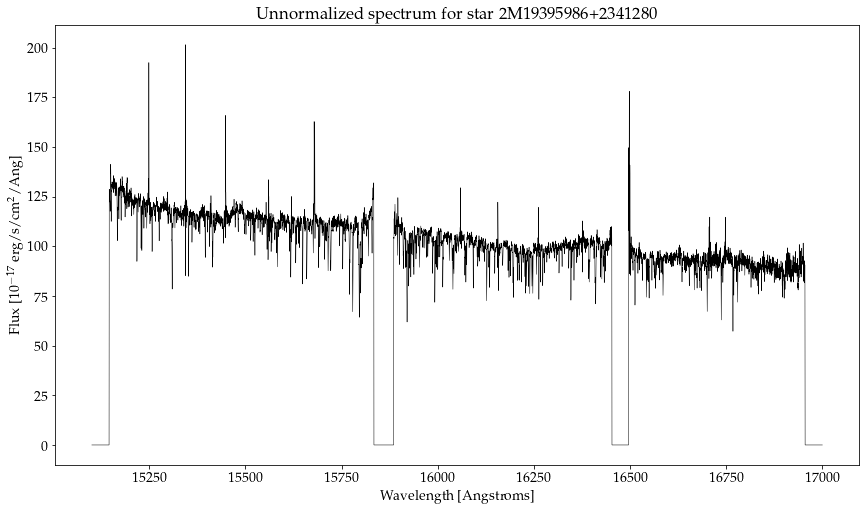

In [193]:
fig, ax = plt.subplots()

ax.plot(wavelength, hdul[1].data[0], color='k', linewidth=0.5)

ax.set_ylabel('Flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_xlabel('Wavelength [Angstroms]')

ax.set_title('Unnormalized spectrum for star 2M19395986+2341280')

In [194]:
plt_wls = np.concatenate((np.array(wl_l), np.array(wl_m), np.array(wl_h)))

Text(0.5, 1.0, 'Pseudo-continuum for star 2M19395986+2341280')

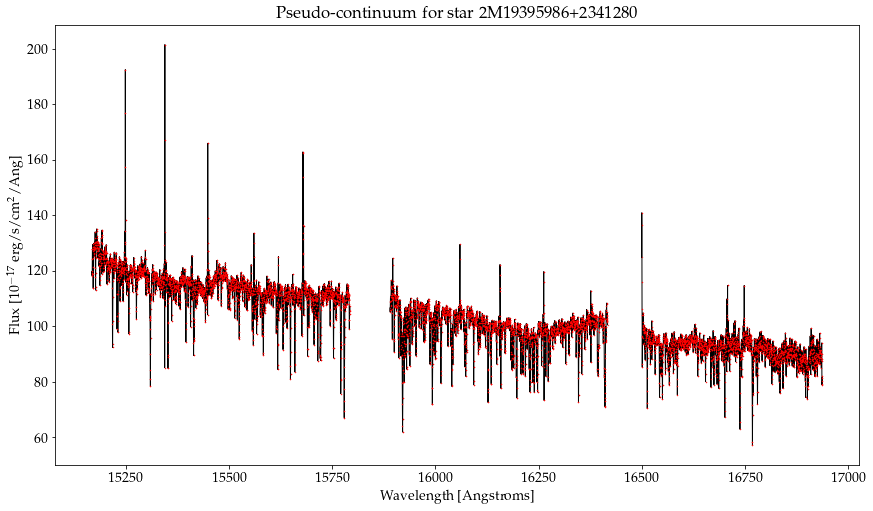

In [195]:
fig, ax = plt.subplots()

ax.scatter(np.array(wl_l)[pc_ind_l], spec_l[pc_ind_l], color='r', s=0.1, zorder=10)
ax.plot(np.array(wl_l)[pc_ind_l], spec_l[pc_ind_l], color='k', linewidth=1.0)

ax.scatter(np.array(wl_m)[pc_ind_m], spec_m[pc_ind_m], color='r', s=0.1, zorder=10)
ax.plot(np.array(wl_m)[pc_ind_m], spec_m[pc_ind_m], color='k', linewidth=1.0)

ax.scatter(np.array(wl_h)[pc_ind_h], spec_h[pc_ind_h], color='r', s=0.1, zorder=10)
ax.plot(np.array(wl_h)[pc_ind_h], spec_h[pc_ind_h], color='k', linewidth=1.0)

ax.set_ylabel('Flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_xlabel('Wavelength [Angstroms]')

ax.set_title('Pseudo-continuum for star 2M19395986+2341280')

Text(0.5, 1.0, 'Continuum for star 2M19395986+2341280')

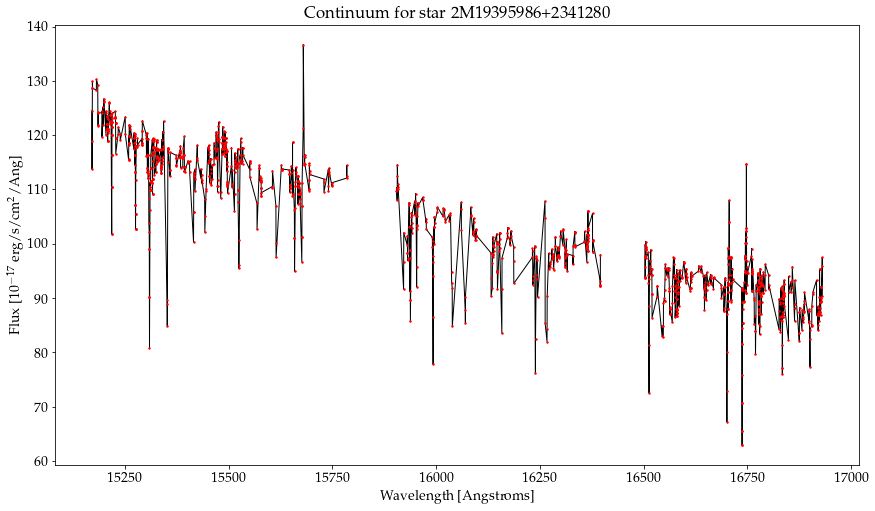

In [196]:
fig, ax = plt.subplots()

ax.scatter(np.array(wl_l)[ind_l], spec_l[ind_l], color='r', s=2.0, zorder=10)
ax.plot(np.array(wl_l)[ind_l], spec_l[ind_l], color='k', linewidth=1.0)

ax.scatter(np.array(wl_m)[ind_m], spec_m[ind_m], color='r', s=2.0, zorder=10)
ax.plot(np.array(wl_m)[ind_m], spec_m[ind_m], color='k', linewidth=1.0)

ax.scatter(np.array(wl_h)[ind_h], spec_h[ind_h], color='r', s=2.0, zorder=10)
ax.plot(np.array(wl_h)[ind_h], spec_h[ind_h], color='k', linewidth=1.0)


ax.set_ylabel('Flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_xlabel('Wavelength [Angstroms]')

ax.set_title('Continuum for star 2M19395986+2341280')

Text(0.5, 1.0, 'Continuum for star 2M19395986+2341280')

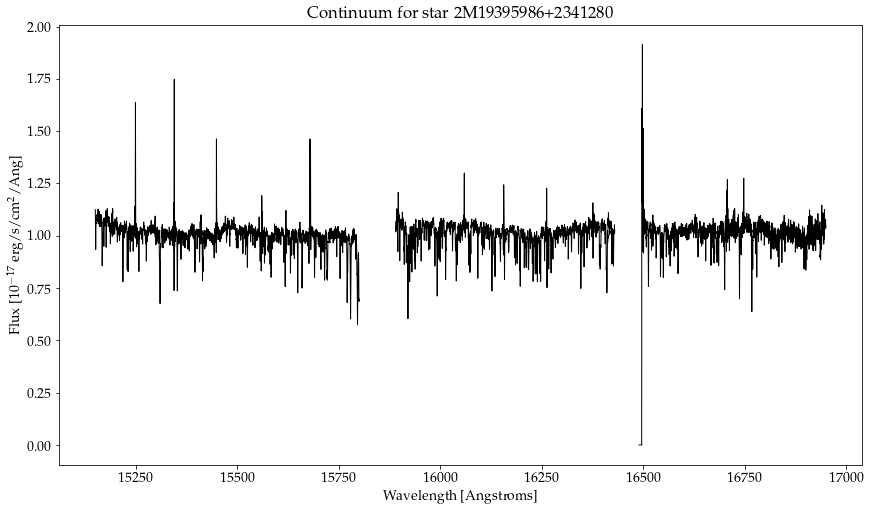

In [197]:
fig, ax = plt.subplots()

ax.plot(wl_l, norm_l[0], color='k', linewidth=1.0)

ax.plot(wl_m, norm_m[0], color='k', linewidth=1.0)

ax.plot(wl_h, norm_h[0], color='k', linewidth=1.0)

ax.set_ylabel('Flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_xlabel('Wavelength [Angstroms]')

ax.set_title('Continuum for star 2M19395986+2341280')

In [198]:
#run through the stars in a for loop

tqdm.tqdm._instances.clear()
for star in tqdm.tqdm(labels_arr, total=len(labels_arr)):
    
    #initialize lists to be stored
    spec_l = []
    spec_m = []
    spec_h = []
    
    errs_l = []
    errs_m = []
    errs_h = []
    
    #adjust the errors based on bitmasks
    star['errors'] = pixel_checker(star['errors'], star['bitmask'])
    
    for i in range(len(wavelength)):
    
        if 15150 < wavelength[i] < 15800:

            spec_l.append(star['spectrum'][i])
            errs_l.append(star['errors'][i])

        if 15890 < wavelength[i] < 16430:

            spec_m.append(star['spectrum'][i])
            errs_m.append(star['errors'][i])

        if 16490 < wavelength[i] < 16950:

            spec_h.append(star['spectrum'][i])
            errs_h.append(star['errors'][i])
    
    #fit the continuum spectra and normalize
    norm_l = normed_spectra(wl_l[ind_l], np.array(spec_l)[ind_l], np.array(errs_l)[ind_l], spec_l, errs_l, wl_l)
    norm_m = normed_spectra(wl_m[ind_m], np.array(spec_m)[ind_m], np.array(errs_m)[ind_m], spec_m, errs_m, wl_m)
    norm_h = normed_spectra(wl_h[ind_h], np.array(spec_h)[ind_h], np.array(errs_h)[ind_h], spec_h, errs_h, wl_h)
    
    #create new dictionary keys and values to store for easy access
    star['norm_spectrum'] = norm_l[0]+norm_m[0]+norm_h[0]
    star['norm_errors'] = norm_l[1]+norm_m[1]+norm_h[1]
    star['wavelength'] = np.concatenate((wl_l,wl_m,wl_h))

100%|██████████| 1847/1847 [16:49<00:00,  1.83it/s]   


# Creating the training set

Below, we create a 3-dimensional box of bins to categorize our stars based upon their labels. The first dimension of bins is the temperature dimension, the second dimension is the $\log{(\text{g})}$ dimension, and the third dimension is the $\text{[Fe/H]}$ dimension. By performing this categorization, we are able to draw stars from each bin to get a good sampling of stars to train our spectral model.

In [199]:
#create a 3-dimensional box of bins to categorize the stars based upon label values

bins = [[] for _ in range(96)]

for star in labels_arr:
    
    if 3000 < star['teff'] < 3500:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[0].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[1].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[2].append(star)
                
            else:
                
                bins[3].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[4].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[5].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[6].append(star)
                
            else:
                
                bins[7].append(star)
                
        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[8].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[9].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[10].append(star)
                
            else:
                
                bins[11].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[12].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[13].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[14].append(star)
                
            else:
                
                bins[15].append(star)
                
    elif 3500 < star['teff'] < 4000:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[16].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[17].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[18].append(star)
                
            else:
                
                bins[19].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[20].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[21].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[22].append(star)
                
            else:
                
                bins[23].append(star)
                
        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[24].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[25].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[26].append(star)
                
            else:
                
                bins[27].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[28].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[29].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[30].append(star)
                
            else:
                
                bins[31].append(star)
                
    elif 4000 < star['teff'] < 4500:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[32].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[33].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[34].append(star)
                
            else:
                
                bins[35].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[36].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[37].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[38].append(star)
                
            else:
                
                bins[39].append(star)
                
        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[40].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[41].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[42].append(star)
                
            else:
                
                bins[43].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[44].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[45].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[46].append(star)
                
            else:
                
                bins[47].append(star)
                
    elif 4500 < star['teff'] < 5000:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[48].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[49].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[50].append(star)
                
            else:
                
                bins[51].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[52].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[53].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[54].append(star)
                
            else:
                
                bins[55].append(star)
                
        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[56].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[57].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[58].append(star)
                
            else:
                
                bins[59].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[60].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[61].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[62].append(star)
                
            else:
                
                bins[63].append(star)
                
    elif 5000 < star['teff'] < 5500:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[64].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[65].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[66].append(star)
                
            else:
                
                bins[67].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[68].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[69].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[70].append(star)
                
            else:
                
                bins[71].append(star)

        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[72].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[73].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[74].append(star)
                
            else:
                
                bins[75].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[76].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[77].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[78].append(star)
                
            else:
                
                bins[79].append(star)
                
    else:
        
        if 0 < star['logg'] < 1:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[80].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[81].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[82].append(star)
                
            else:
                
                bins[83].append(star)
                
        elif 1 < star['logg'] < 2:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[84].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[85].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[86].append(star)
                
            else:
                
                bins[87].append(star)
                
        elif 2 < star['logg'] < 3:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[88].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[89].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[90].append(star)
                
            else:
                
                bins[91].append(star)
                
        elif 3 < star['logg'] < 4:
            
            if -1 < star['fe_h'] < -0.6:
                
                bins[92].append(star)
                
            elif -0.6 < star['fe_h'] < -0.3:
                
                bins[93].append(star)
                
            elif -0.3 < star['fe_h'] < 0.0:
                
                bins[94].append(star)
                
            else:
                
                bins[95].append(star)

In [200]:
#initialize lists to separate the data from the bins created above

training_set = []
training_set_errs = []
training_set_name = []
training_set_stars = []
X = []
validation_labels = []
validation_set = []
validation_set_errs = []
validation_set_name = []


#initializes the seed for random number generation for our sampling process

np.random.seed(int(time.time()))


#loop which goes through each bin and samples stars randomly for our training and cross-validation sets

for bin in bins:
    
    n = len(bin)
    i = 0
    
    while i < n/2:
        
        j=np.random.randint(0, len(bin))
        training_set.append(bin[j]['norm_spectrum'])
        training_set_errs.append(bin[j]['norm_errors'])
        training_set_name.append(bin[j]['filename'])
        training_set_stars.append(bin[j])
        
        teff = bin[j]['teff']/5700
        logg = bin[j]['logg']/4
        fe_h = bin[j]['fe_h']
        mg_fe = bin[j]['mg_fe']
        si_fe = bin[j]['si_fe']
        
        l = [1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h, teff*mg_fe,
             teff*si_fe, logg**2, logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
             fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]
        X.append(l)
        
        bin[j]['ell'] = [1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h, teff*mg_fe,
                         teff*si_fe, logg**2,logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
                         fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]
        
        i+=1
        
    while i < n:
        
        j=np.random.randint(0, len(bin))
        teff = bin[j]['teff']/5700
        logg = bin[j]['logg']/4
        fe_h = bin[j]['fe_h']
        mg_fe = bin[j]['mg_fe']
        si_fe = bin[j]['si_fe']
        
        validation_labels.append([1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h,
                                  teff*mg_fe, teff*si_fe, logg**2,logg*fe_h, logg*mg_fe, logg*si_fe,
                                  fe_h**2, fe_h*mg_fe, fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2])
        
        bin[j]['ell'] = [1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h, teff*mg_fe,
                         teff*si_fe, logg**2,logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
                        fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]
        
        validation_set.append(bin[j])
        
        i+=1

        
X = np.array(X)
training_set = np.array(training_set)
training_set_errs = np.array(training_set_errs)
training_set_name = np.array(training_set_name)
validation_set = np.array(validation_set)
validation_set_errs = np.array(validation_set_errs)
validation_set_name = np.array(validation_set_name)
train_set_T = np.matrix.transpose(training_set)
train_set_errs_T = np.matrix.transpose(training_set_errs)

In [201]:
'''
loop which creates the $\ell$ vector defined in Ness et al. 2015 to be used for training
the spectral model and then for determining the labels in the cross-validation step
'''

for star in labels_arr:
    
    teff = star['teff']/5700
    logg = star['logg']/4
    fe_h = star['fe_h']
    mg_fe = star['mg_fe']
    si_fe = star['si_fe']

    star['ell'] = [1, teff, logg, fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*fe_h, teff*mg_fe, teff*si_fe,
                             logg**2,logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
                             fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

# Creating the spectral model

According to [Ness et al. 2015](https://arxiv.org/abs/1501.07604), we can derive the flux at a specific pixel for a specific star $f_{n\lambda}$ and a fixed scatter $s_{\lambda}^2$ by using the following quadratic-in-labels equation:

$$
f_{n\lambda} = \mathbf{\theta}_{\lambda}^T \cdot \mathbf{\ell}_{n} + \text{noise},
$$

where $\mathbf{\theta}_{\lambda}^T$ is a vector of undetermined coefficients and $\mathbf{\ell}_{n}$ is a vector that is quadratic in labels:

$$
\ell_{n} = \begin{bmatrix} 1, T_{\text{eff}}, \log{(g)},..., [\text{Fe/H}],...,T_{\text{eff}}^2, T_{\text{eff}}\cdot\log{(g)},...,[\text{Fe/H}]^2\end{bmatrix}.
$$

Since we are using a model with 5 labels, the dimension of $\ell_{n}$, and therefore the number of coefficients we will have, will be $\sum_{n=1}^{6} {n \choose 1}=21$. Hence, we can create a matrix equation as follows:

$$
\mathbf{X}\mathbf{\theta}_{\lambda} = \mathbf{f_{\lambda}},
$$

where

$$
\mathbf{X} = \begin{bmatrix}
\ell_1 \\
\ell_2 \\
\vdots \\
\ell_n \\
\end{bmatrix}.
$$

Now, $\mathbf{X}$ has dimensions $n \times 21$. So, we can solve for $\mathbf{\theta}_{\lambda}$ as follows:

$$
\mathbf{\theta}_{\lambda} = (\mathbf{X}^\text{T}\mathbf{X})^{-1}\mathbf{X}^\text{T}\mathbf{f}_{\lambda}.
$$

In [202]:
'''
loop which calls the spectrum_optimize function to use for determining $\theta_{\lambda}$ defined above
and $s_{\lambda}^2$ for our spectral model which will be important in our cross-validation step
'''

tqdm.tqdm._instances.clear()

results = [spectrum_optimize(X, flux, errs, [0, 5]) for \
           flux, errs in tqdm.tqdm(zip(train_set_T, train_set_errs_T), total=len(train_set_T))]

  0%|          | 0/7449 [00:00<?, ?it/s]<ipython-input-180-5d07095ad95f>:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(Xw, Fw)[0]
100%|██████████| 7449/7449 [11:46<00:00, 10.55it/s]


# What does our scatter look like?

We can see that for most of our wavelengths that the scatter values are relatively close to zero which indicates that our spectra have been normalized properly and more importantly that our assumption that stars that have identical labels have identical spectra is a good assumption to make. This assumption is crucial to determine what the labels are given spectra from stars which we do not know the labels of.

<ipython-input-203-e8446be68023>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(labels_arr[0]['wavelength'], np.matrix.transpose(np.array(results))[1], s=0.1, color='k')


Text(0, 0.5, '$s_{\\lambda}^2$')

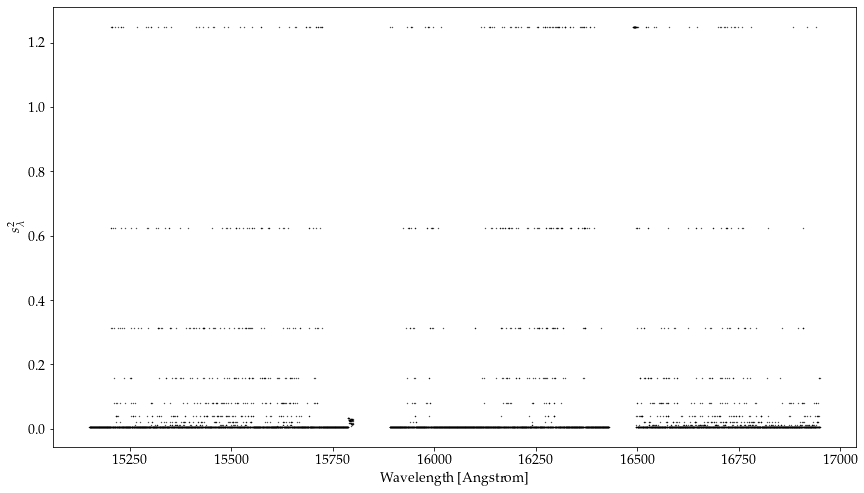

In [203]:
plt.scatter(labels_arr[0]['wavelength'], np.matrix.transpose(np.array(results))[1], s=0.1, color='k')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('$s_{\\lambda}^2$')

In [204]:
i = 0

theta_arr = []
err_arr = []

'''
loop that runs through our results from the spectrum_optimize function and creates a matrix of theta values
and an array of our scatter values
'''

for theta, err in zip(np.matrix.transpose(np.array(results))[0], np.matrix.transpose(np.array(results))[1]):
    
    theta_arr.append(theta.tolist())
    err_arr.append(err)
    
theta_arr=np.array(theta_arr)

'''
loop that runs through each star and calculates the spectrum according to the stars labels and the matrix
of theta values which we created with the previous loop
'''

tqdm.tqdm._instances.clear()
for star in tqdm.tqdm(labels_arr, total=len(labels_arr)):
    
    star['CANNON_spectrum'] = [np.dot(theta, star['ell']) for theta in theta_arr]
        
    if star['filename'] == '2M03533659+2512012':
        
        index = i
        
    i+=1

<ipython-input-204-94e6e7d2402a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta, err in zip(np.matrix.transpose(np.array(results))[0], np.matrix.transpose(np.array(results))[1]):
100%|██████████| 1847/1847 [00:48<00:00, 37.91it/s]


# Our results?

Looking at our spectrum versus the spectrum obtained via observations that our spectrum matches up rather nicely in all of the smaller details and exceptionally well in the overall behavior. We observe that there are some discrepancies in the maximal values especially and less so in the minimal values. Thus, we can conclude that our model is attempting to determine with some degree of accuracy primarily where the absorption lines are which was one of the main purposes of this enterprise in the first place. As for the discrepancies between the calculated maxima and the actual maxima, it is possible that these pixels suffer from problems such as persistence (described below in our cross-validation analysis) or that our model does not take into enough variables such as other element concentrations, rotation, and so on. Lastly, we note that our residuals are distributed above and below 0 which corroborates the robustness of our model and indicates that there are no errors in our weighted least squares fit we employed in training the model.

Text(0.5, 1.0, 'Comparison between trained model and\nAPOGEE spectrum for star 2M03533659+2512012')

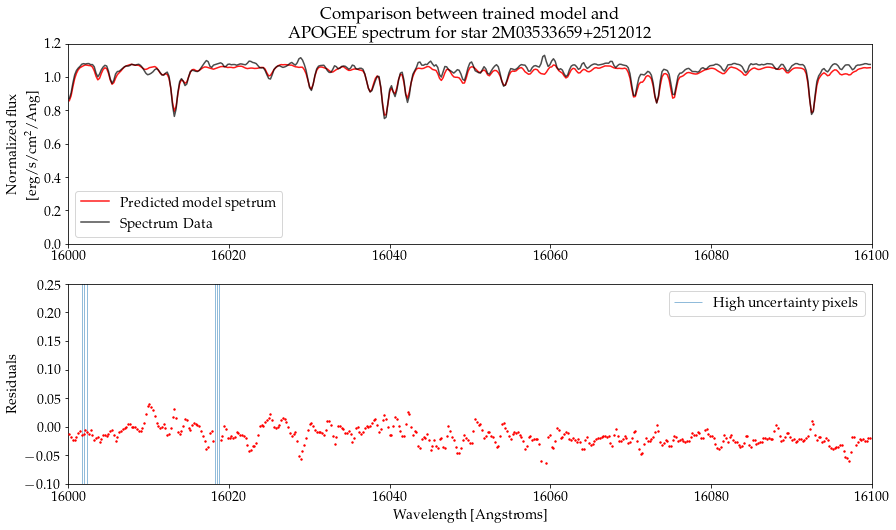

In [205]:
inds = np.where((labels_arr[index]['wavelength'] > 16000) & (labels_arr[index]['wavelength'] < 16100)
                & (np.array(labels_arr[index]['norm_spectrum'])>0.0))[0]

fig, [ax1, ax2] = plt.subplots(2, 1)

ax1.plot(labels_arr[index]['wavelength'][inds], np.array(labels_arr[index]['CANNON_spectrum'])[inds], color='r',
         alpha=0.9, linewidth=1.5, label='Predicted model spetrum')
ax1.plot(labels_arr[index]['wavelength'][inds],
         np.array(labels_arr[index]['norm_spectrum'])[inds],
         color='k',alpha=0.7, linewidth=1.5, label='Spectrum Data')
ax1.set_xlim(16000, 16100)
ax1.set_ylim(0, 1.2)
ax1.legend()

ax1.set_ylabel('Normalized flux \n[erg/s/cm$^2$/Ang]')

ax2.scatter(labels_arr[index]['wavelength'][inds], (np.array(labels_arr[index]['CANNON_spectrum'])-\
            np.array(labels_arr[index]['norm_spectrum']))[inds],
            s=2.0, color='r', zorder=10)
ax2.vlines(np.array(labels_arr[index]['wavelength'])[np.where((np.array(labels_arr[index]['norm_errors']) > 10) & \
           (np.array(labels_arr[index]['wavelength']) < 16080))[0]], -1, 2.0,linewidth=0.7, alpha=0.7,
           label='High uncertainty pixels')
ax2.set_xlim(16000, 16100)
ax2.set_ylim(-0.1, 0.25)
ax2.legend()

ax2.set_xlabel('Wavelength [Angstroms]')
ax2.set_ylabel('Residuals')

ax1.set_title('Comparison between trained model and\nAPOGEE spectrum for star 2M03533659+2512012')

# Further comparisons?

Below we have plotted some further comparisons to display the robustness of our spectral model in determining the spectra of various stars within not only our training set but the cross-validation set as well. We notice that most high residuals occur at the ends of the chips where are normalizations were unable to take account of the endpoints properly. We make note that in the future it may be more appropriate to take into further account the approximate derivative behavior of the spectra to extrapolate further what the overall spectrum behavior is outside of the chips. We also see some spectra are wildly off due to our normalized spectra having rapidly changing underlying blackbody curve behavior. This could possibly be due to our normalization process and errors not being taken into account properly. We also suspect that it could be due to other flags which we did not analyze previously such as the ASPCAP and Star flags contained in the allStar .fits file.

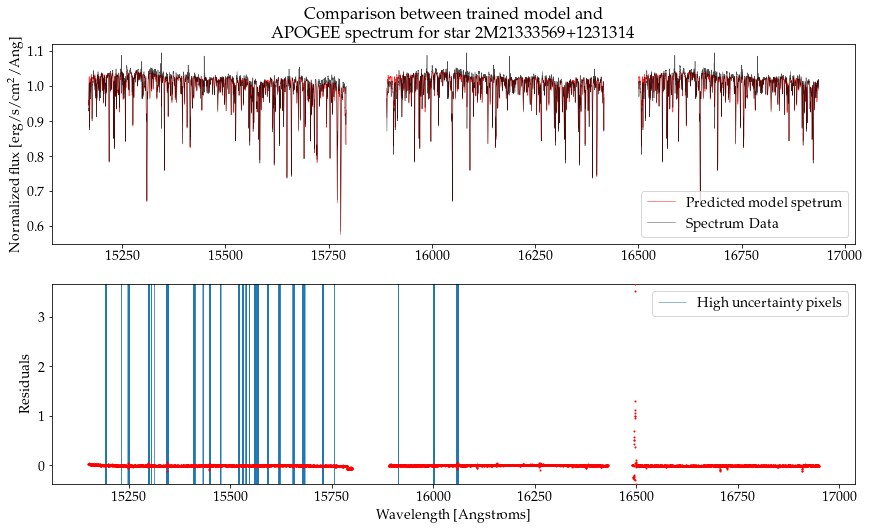

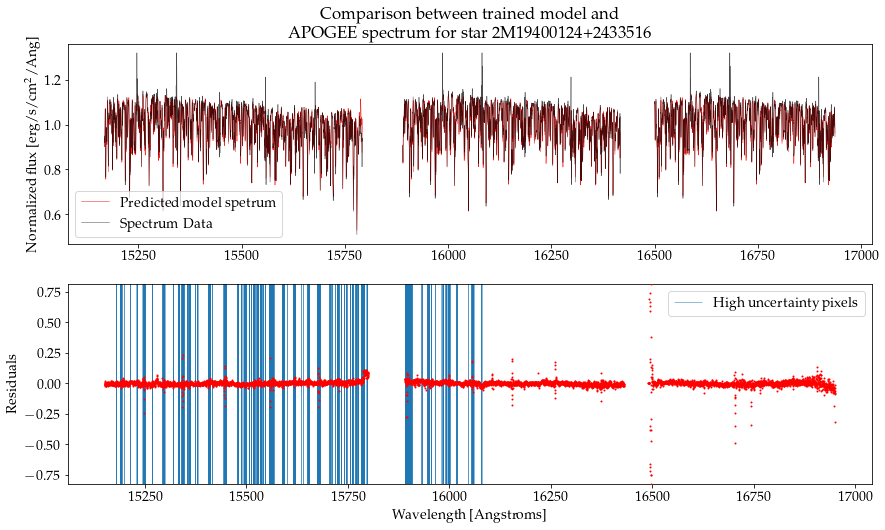

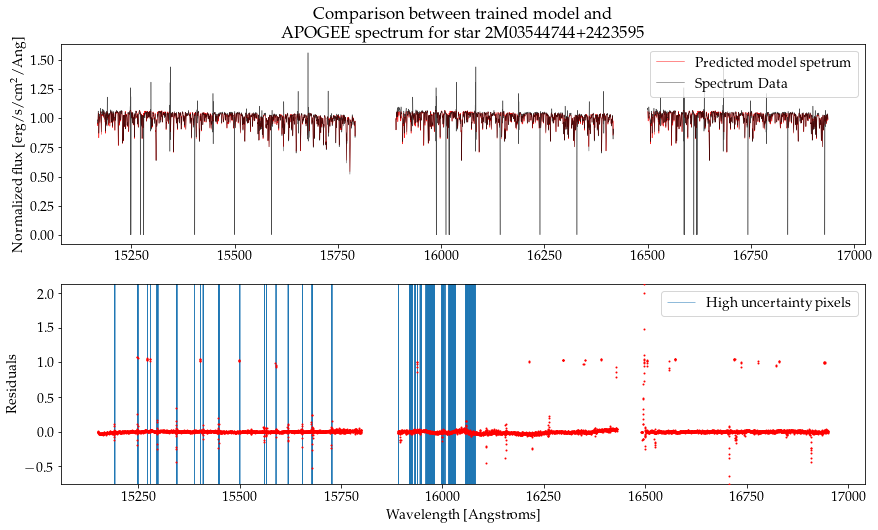

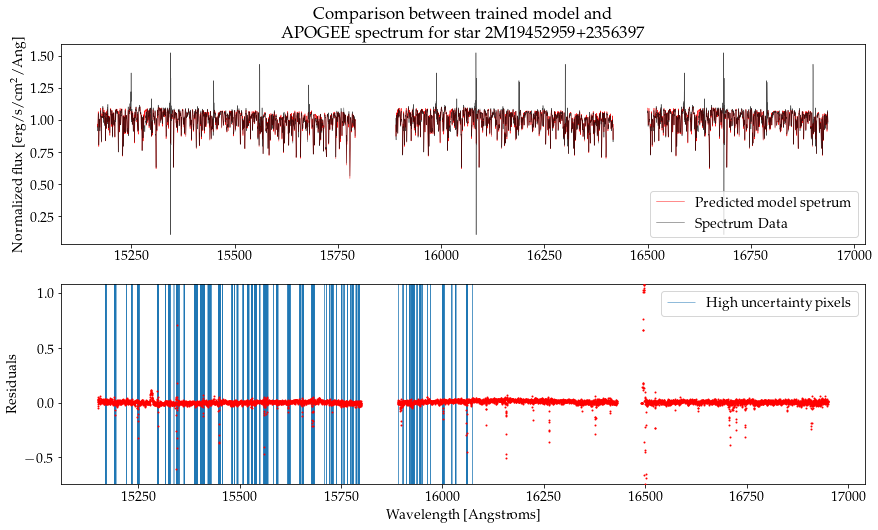

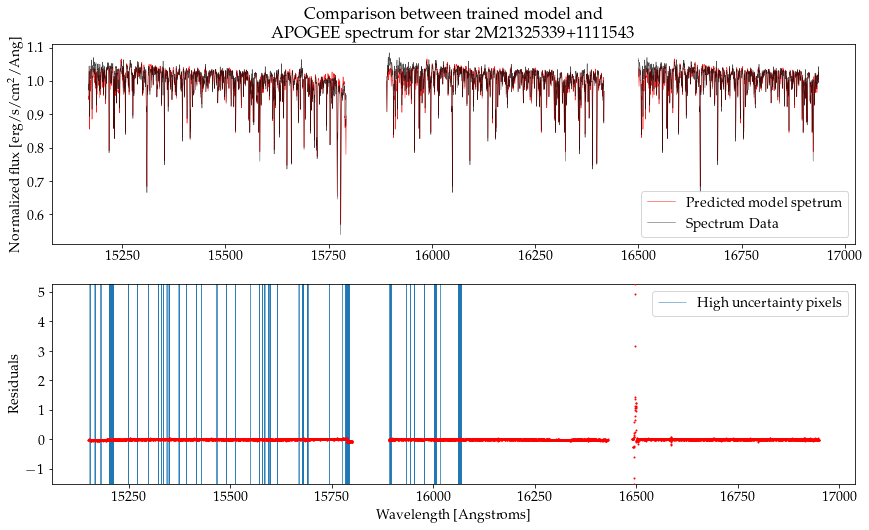

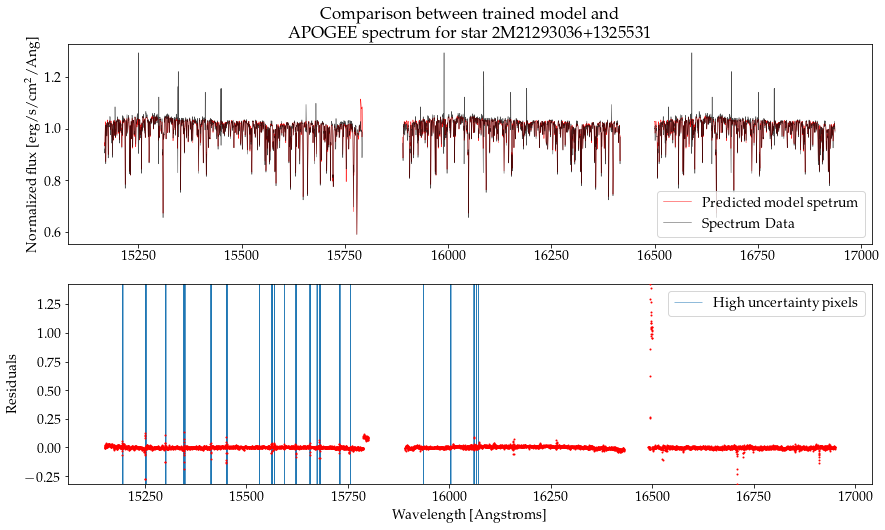

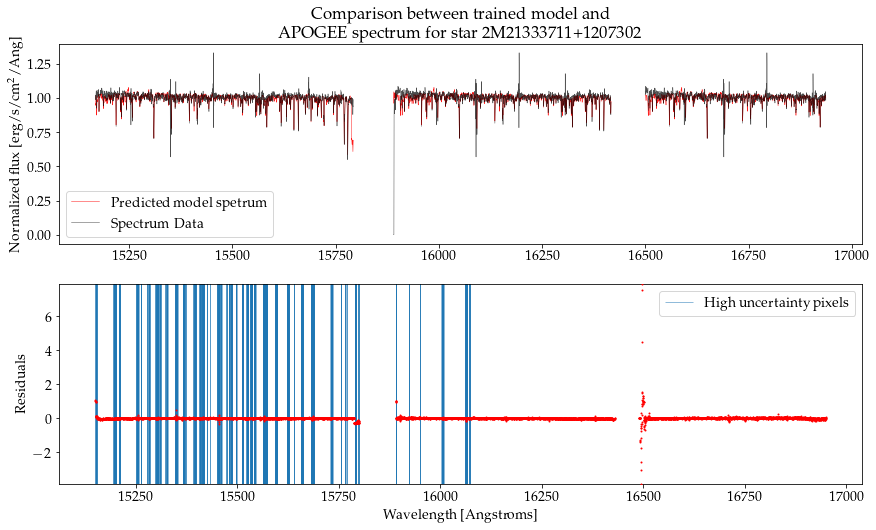

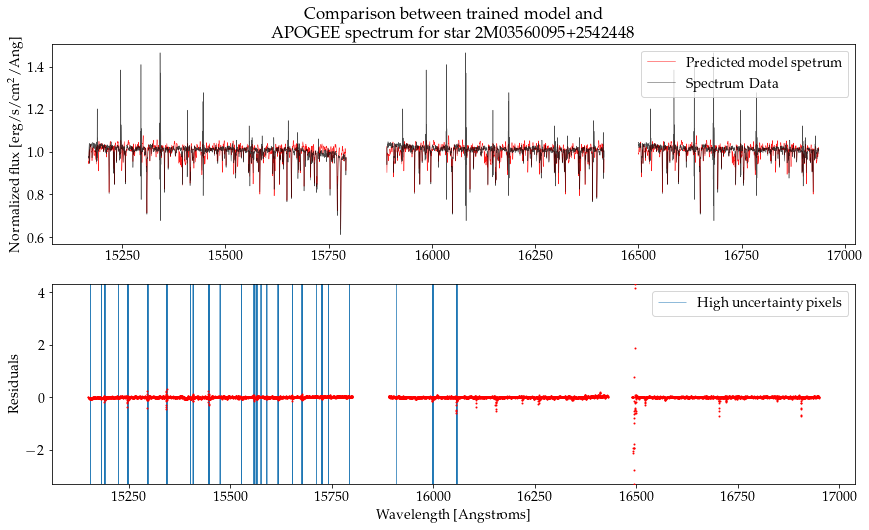

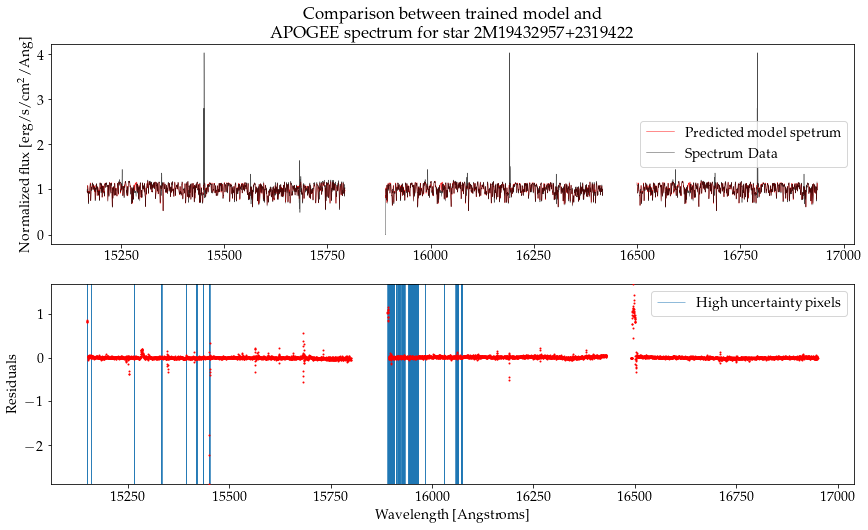

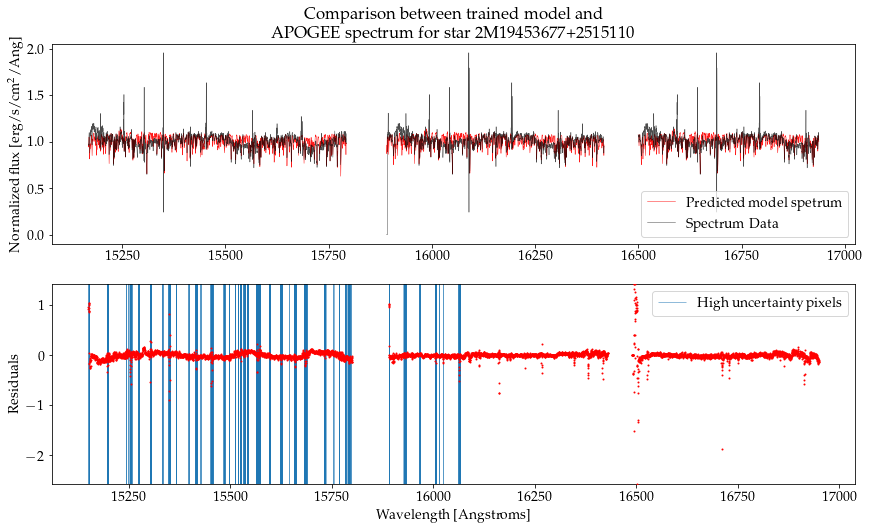

In [206]:
for i in range(10):

    rand_ind = np.random.randint(0, 1847)
    
    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.plot(np.array(wl_l)[pc_ind_l],np.array(labels_arr[rand_ind]['CANNON_spectrum'])[pc_ind_l], color='r',
             alpha=0.9, linewidth=0.5, label='Predicted model spetrum')
    ax1.plot(np.array(wl_m)[pc_ind_m],np.array(labels_arr[rand_ind]['CANNON_spectrum'])[pc_ind_m], color='r',
             alpha=0.9, linewidth=0.5)
    ax1.plot(np.array(wl_h)[pc_ind_h],np.array(labels_arr[rand_ind]['CANNON_spectrum'])[pc_ind_h], color='r',
             alpha=0.9, linewidth=0.5)
    ax1.plot(np.array(wl_l)[pc_ind_l],np.array(labels_arr[rand_ind]['norm_spectrum'])[pc_ind_l], color='k',
             alpha=0.7, linewidth=0.5, label='Spectrum Data')
    ax1.plot(np.array(wl_m)[pc_ind_m],np.array(labels_arr[rand_ind]['norm_spectrum'])[pc_ind_m], color='k',
             alpha=0.7, linewidth=0.5)
    ax1.plot(np.array(wl_h)[pc_ind_h],np.array(labels_arr[rand_ind]['norm_spectrum'])[pc_ind_h], color='k',
             alpha=0.7, linewidth=0.5)
    ax1.legend()
    
    ax1.set_ylabel('Normalized flux [erg/s/cm$^2$/Ang]')

    ax2.scatter(labels_arr[rand_ind]['wavelength'], (np.array(labels_arr[rand_ind]['CANNON_spectrum'])-\
                np.array(labels_arr[rand_ind]['norm_spectrum'])), s=1.0, color='r', zorder=10)
    ax2.vlines(np.array(labels_arr[rand_ind]['wavelength'])[np.where((np.array(labels_arr[rand_ind]['norm_errors']) > 1000) & \
               (np.array(labels_arr[rand_ind]['wavelength']) < 16080))[0]], -10.0, 10.0,linewidth=0.7, alpha=0.7,
               label='High uncertainty pixels')
    ax2.legend()
    ax2.set_xlabel('Wavelength [Angstroms]')
    ax2.set_ylabel('Residuals')
    ax2.set_ylim(np.min(np.array(labels_arr[rand_ind]['CANNON_spectrum'])-\
                np.array(labels_arr[rand_ind]['norm_spectrum'])), np.max(np.array(labels_arr[rand_ind]['CANNON_spectrum'])-\
                np.array(labels_arr[rand_ind]['norm_spectrum'])))

    ax1.set_title(f'Comparison between trained model and\nAPOGEE spectrum for star {labels_arr[rand_ind]["filename"]}')

In [207]:
#initialize dictionary

star={}


#loop to obtain a star to analyze the flux gradient of

for stars in labels_arr:
    
    if stars['mg_fe'] > 0.25 and stars['si_fe'] > 0.3 and stars['fe_h'] < -0.8:
        
        star=stars

# Flux gradient

We wish to analyze the flux gradient to see how the flux changes with variations in each label. We know that flux is a function of 6 quantities: $\lambda, \text{T}_{\text{eff}}, [Fe/H], [Mg/Fe], \text{ and } [Si/Fe]$. Thus, by looking at $\frac{\partial{f}}{\partial{\ell_i}}$ where $\ell_i$ is one of the labels we can see where we should expect absorption lines and thus see how our spectral model compares with other theoretical predictions.

## Temperature

We see that as temperature changes, there is almost negligible change in the flux and is on the order of $10^{-5}$. We do see some spots where it the flux does have a greater change with regards to a change in the temperature but it is entirely possible that these changes are due to errors in the spectra and not actually due to some sort of physical phenomena.

## log(g)

We see a greater change in the flux as $\log{(\text{g})}$ varies, but again this change is on the order of $10^{-2}$. There are some spots where the change is rapid, but again this could entirely be due to errors and we would have to cross-check these changes with uncertain pixels for each star to see if there is a trend that holds that we can confidently say exists.

## [Fe/H]

In this graph, we see much greater variations in the flux on the order of unity or greater as we vary the [Fe/H] concentration. This indicates that the metallicity of the stellar atmosphere plays a large role in determining the spectral intensity of a star. This is to be expected and matches with theoretical predictions.

## [Mg/Fe]

We see that some of the dips in the spectrum correspond to the absorption lines for Mg. We also see large variations in the flux as the label value changes at each wavelength. This indicates that there is a strong dependence upon the Mg concentration relative to the fe concentration in the stellar atmosphere.

## [Si/Fe]

Again, as we saw with the other metals before there is a strong dependence upon the Si concentration relative to the Fe concentration in the stellar atmosphere which indicates that we should see absorption lines or not see absorption lines  depending upon what the concentrations in the atmosphere are. One troubling issue we see, however, is that these dips do not correspond nicely with the absorption lines. However, we are only looking at one star and varying around what its ASPCAP values are. It is possible by analyzing numerous stars that we would see the absorption lines match nicely with the flux drops.

<ipython-input-208-b2203f58f3fa>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:


(-5e-05, 5e-05)

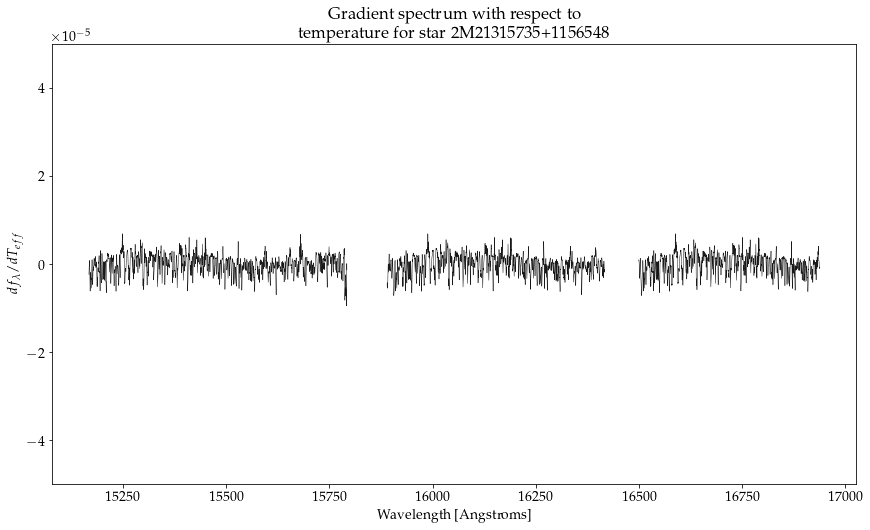

In [208]:
new_teff=(star['teff']+0.03*star['teff'])/5700
logg=star['logg']/4
fe_h=star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, new_teff, logg, fe_h, mg_fe, si_fe, new_teff**2, new_teff*logg, new_teff*fe_h, new_teff*mg_fe, new_teff*si_fe,
                             logg**2,logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
                             fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_teff-star['teff'])

fig, ax = plt.subplots()

ax.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='k', linewidth=0.5, alpha=0.9)
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('$df_{\\lambda}/dT_{{eff}}$')
ax.set_title(f'Gradient spectrum with respect to\ntemperature for star {star["filename"]}')
ax.set_ylim(-0.00005, 0.00005)

<ipython-input-209-f28bfa836b29>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:


(-0.02, 0.02)

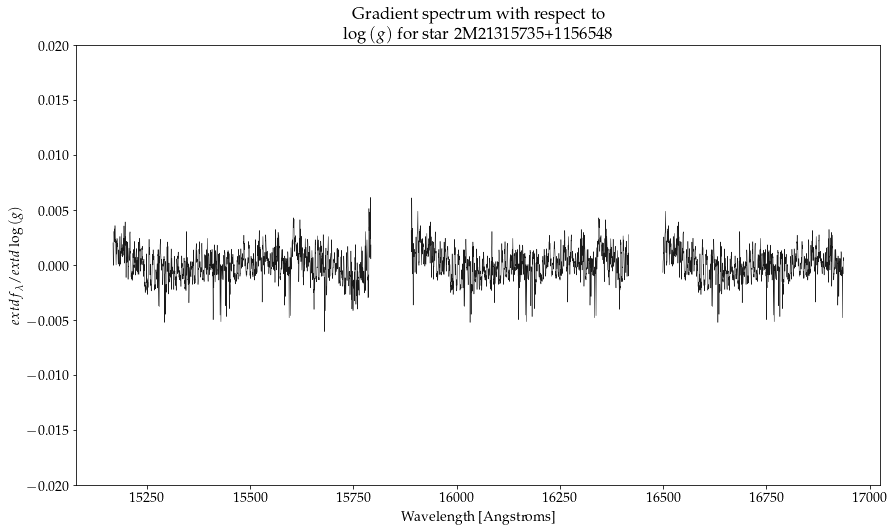

In [209]:
teff=star['teff']/5700
new_logg=(star['logg']+0.03*star['logg'])/4
fe_h=star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, teff, new_logg, fe_h, mg_fe, si_fe, teff**2, teff*new_logg, teff*fe_h, teff*mg_fe, teff*si_fe,
                             new_logg**2,new_logg*fe_h, new_logg*mg_fe, new_logg*si_fe, fe_h**2, fe_h*mg_fe,
                             fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_logg-star['logg'])

fig, ax = plt.subplots()

ax.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='k', linewidth=0.5, alpha=0.9)
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('$\text{df}_{\lambda}/\text{d}\log{(g)}$')
ax.set_title('Gradient spectrum with respect to\n$\log{(g)}$ for star 2M21315735+1156548')
ax.set_ylim(-0.02, 0.02)

<ipython-input-210-bc9c28465723>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:


Text(0.5, 1.0, 'Gradient spectrum with respect to\n[Fe/H] for star 2M21315735+1156548')

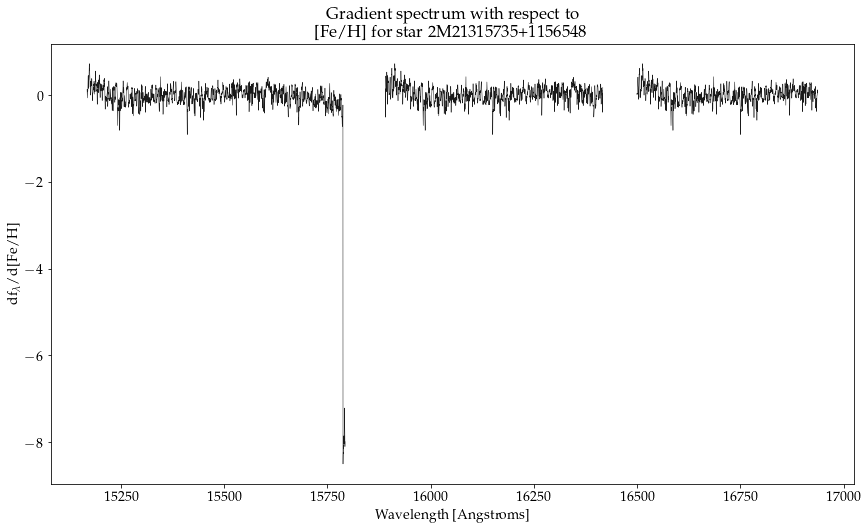

In [210]:
teff=star['teff']/5700
logg=star['logg']/4
new_fe_h=star['fe_h']+0.03*star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, teff, logg, new_fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*new_fe_h, teff*mg_fe, teff*si_fe,
                             logg**2,logg*new_fe_h, logg*mg_fe, new_logg*si_fe, new_fe_h**2, new_fe_h*mg_fe,
                             new_fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_fe_h-star['fe_h'])

fig, ax = plt.subplots()

ax.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='k', linewidth=0.5, alpha=0.9)
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('df$_{\\lambda}/$d[Fe/H]')
ax.set_title('Gradient spectrum with respect to\n[Fe/H] for star 2M21315735+1156548')

<ipython-input-211-fae1b7e0d6bb>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:


(-1.5, 1.5)

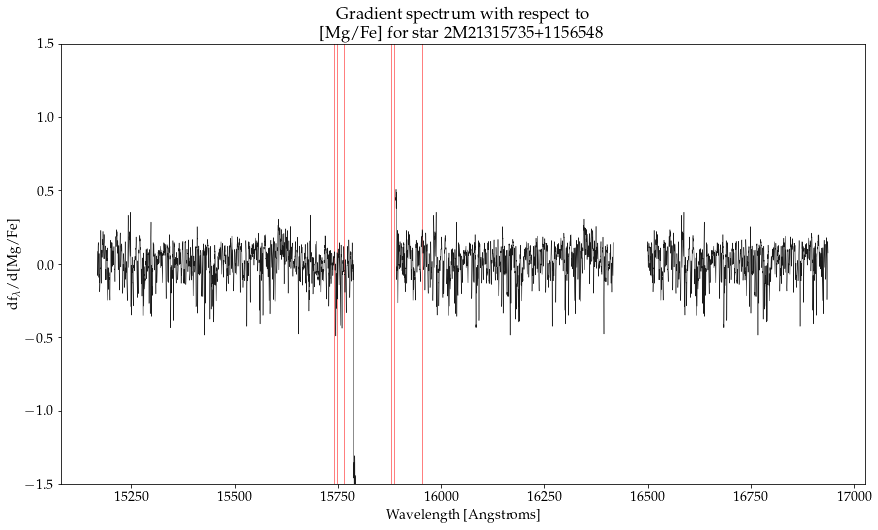

In [211]:
teff=star['teff']/5700
logg=star['logg']/4
fe_h=star['fe_h']
new_mg_fe=star['mg_fe']+0.03*star['mg_fe']
si_fe=star['si_fe']
ell = [1, teff, logg, fe_h, new_mg_fe, si_fe, teff**2, teff*logg, teff*fe_h, teff*new_mg_fe, teff*si_fe,
                             logg**2,logg*fe_h, logg*new_mg_fe, logg*si_fe, fe_h**2, fe_h*new_mg_fe,
                             fe_h*si_fe, new_mg_fe**2, new_mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_mg_fe-star['mg_fe'])

fig, ax = plt.subplots()

ax.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='k', linewidth=0.5, alpha=0.9)
ax.vlines([15740.716,15748.9,15765.8,15879.5,15886.2,15954.477], -3, 3, color='r', lw=0.5)
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('df$_{\\lambda}/$d[Mg/Fe]')
ax.set_title('Gradient spectrum with respect to\n[Mg/Fe] for star 2M21315735+1156548')
ax.set_ylim(-1.5, 1.5)

<ipython-input-212-859617e575f1>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:


(-3.0, 3.0)

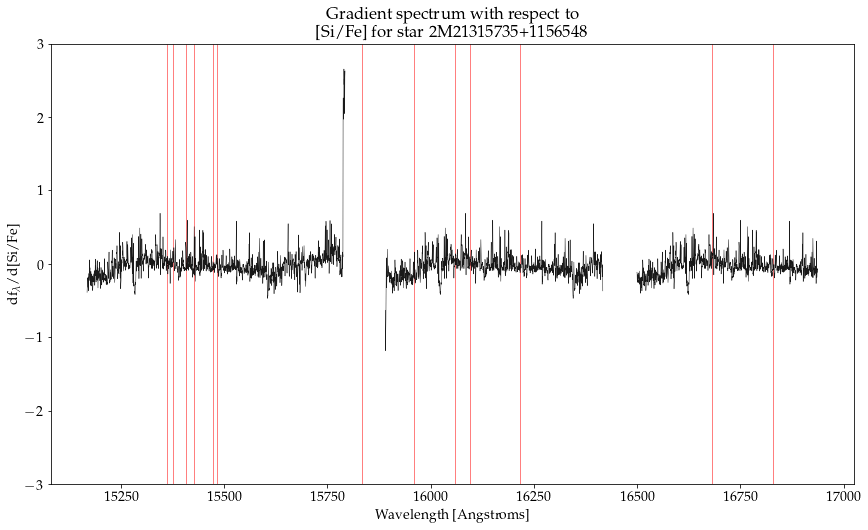

In [212]:
teff=star['teff']/5700
logg=star['logg']/4
fe_h=star['fe_h']
mg_fe=star['mg_fe']
new_si_fe=star['si_fe']+0.03*star['si_fe']
ell = [1, teff, logg, fe_h, mg_fe, new_si_fe, teff**2, teff*logg, teff*fe_h, teff*mg_fe, teff*new_si_fe,
                             logg**2,logg*fe_h, logg*mg_fe, logg*new_si_fe, fe_h**2, fe_h*mg_fe,
                             fe_h*new_si_fe, mg_fe**2, mg_fe*new_si_fe, new_si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_si_fe-star['si_fe'])

fig, ax = plt.subplots()

ax.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='k', linewidth=0.5, alpha=0.9)
ax.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='k', linewidth=0.5, alpha=0.9)
ax.vlines([15361.161,15376.831,15833.602,15960.063,
           16060.009,16094.787,16215.670,16680.770,
           16828.159,15406.540,15426.490,15474.043,
           15482.712], -3, 3, color='r', lw=0.5)
ax.set_xlabel('Wavelength [Angstroms]')
ax.set_ylabel('df$_{\\lambda}/$d[Si/Fe]')
ax.set_title('Gradient spectrum with respect to\n[Si/Fe] for star 2M21315735+1156548')
ax.set_ylim(-3.0, 3.0)

<ipython-input-213-ad9be64a4281>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:
<ipython-input-213-ad9be64a4281>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta in np.matrix.transpose(np.array(results))[0]:
<ipython-input-213-ad9be64a4281>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' wh

Text(0.5, 0.04, 'wavelength [Angstroms]')

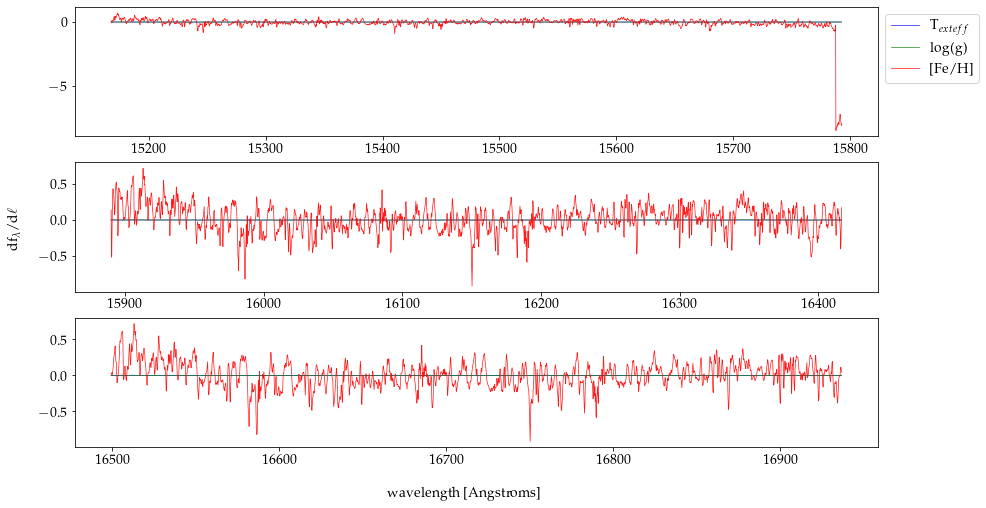

In [213]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1)

new_teff=(star['teff']+0.03*star['teff'])/5700
logg=star['logg']/4
fe_h=star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, new_teff, logg, fe_h, mg_fe, si_fe, new_teff**2, new_teff*logg, new_teff*fe_h,
       new_teff*mg_fe, new_teff*si_fe,
        logg**2,logg*fe_h, logg*mg_fe, logg*si_fe, fe_h**2, fe_h*mg_fe,
        fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_teff-star['teff'])

ax1.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='b', linewidth=0.7, alpha=0.9,
         label='T$_{\text{eff}}$')
ax2.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='b', linewidth=0.7, alpha=0.9)
ax3.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='b', linewidth=0.7, alpha=0.9)

teff=star['teff']/5700
new_logg=(star['logg']+0.03*star['logg'])/4
fe_h=star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, teff, new_logg, fe_h, mg_fe, si_fe, teff**2, teff*new_logg, teff*fe_h, teff*mg_fe, teff*si_fe,
                             new_logg**2,new_logg*fe_h, new_logg*mg_fe, new_logg*si_fe, fe_h**2, fe_h*mg_fe,
                             fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_logg-star['logg'])

ax1.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='g', linewidth=0.7, alpha=0.9, label='log(g)')
ax2.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='g', linewidth=0.7, alpha=0.9)
ax3.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='g', linewidth=0.7, alpha=0.9)

teff=star['teff']/5700
logg=star['logg']/4
new_fe_h=star['fe_h']+0.03*star['fe_h']
mg_fe=star['mg_fe']
si_fe=star['si_fe']
ell = [1, teff, logg, new_fe_h, mg_fe, si_fe, teff**2, teff*logg, teff*new_fe_h, teff*mg_fe, teff*si_fe,
                             logg**2,logg*new_fe_h, logg*mg_fe, new_logg*si_fe, new_fe_h**2, new_fe_h*mg_fe,
                             new_fe_h*si_fe, mg_fe**2, mg_fe*si_fe, si_fe**2]

new_spec = []

for theta in np.matrix.transpose(np.array(results))[0]:

    new_spec.append(np.dot(theta, ell))
                    
delta_spec=(np.array(new_spec)-star['CANNON_spectrum'])/(new_fe_h-star['fe_h'])

ax1.plot(np.array(wl_l)[pc_ind_l], delta_spec[pc_ind_l], color='r', linewidth=0.7, alpha=0.9, label='[Fe/H]')
ax2.plot(np.array(wl_m)[pc_ind_m], delta_spec[pc_ind_m], color='r', linewidth=0.7, alpha=0.9)
ax3.plot(np.array(wl_h)[pc_ind_h], delta_spec[pc_ind_h], color='r', linewidth=0.7, alpha=0.9)

ax1.legend(bbox_to_anchor=(1.00, 1.0))
fig.text(0.06, 0.5, 'df$_{\lambda}$/d$\\ell$', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'wavelength [Angstroms]', ha='center')

Using matplotlib backend: nbAgg


<ipython-input-267-6e15422e05c8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(np.array(wl_l)[pc_ind_l], np.matrix.transpose(np.array(results))[1][pc_ind_l], color='k', s=1.0, alpha=1.0)


<IPython.core.display.Javascript object>


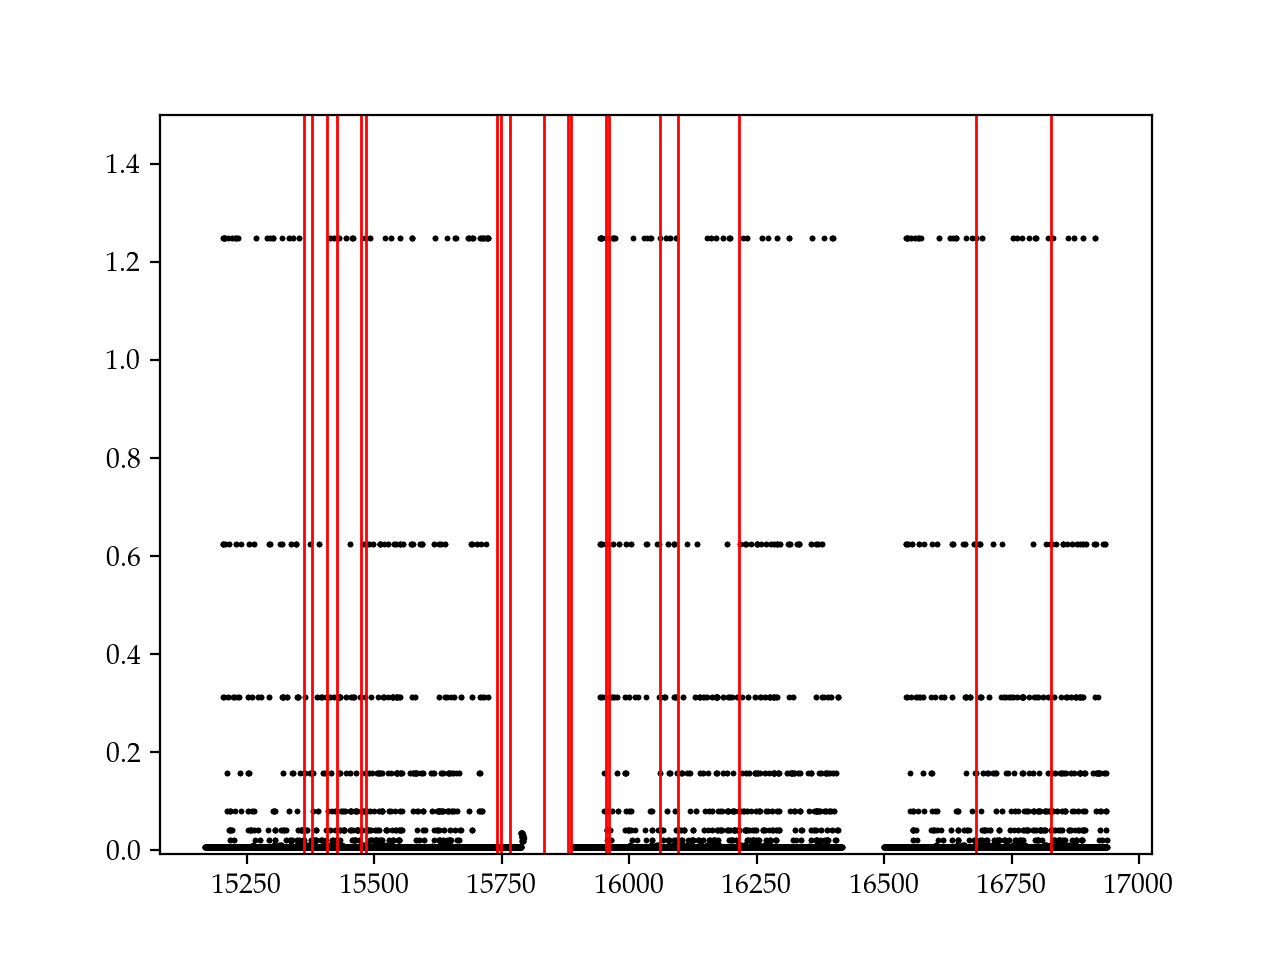

<ipython-input-267-6e15422e05c8>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(np.array(wl_m)[pc_ind_m], np.matrix.transpose(np.array(results))[1][pc_ind_m], color='k', s=1.0, alpha=1.0)
<ipython-input-267-6e15422e05c8>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(np.array(wl_h)[pc_ind_h], np.matrix.transpose(np.array(results))[1][pc_ind_h], color='k', s=1.0, alpha=1.0)


(-0.01, 1.5)

In [267]:
%matplotlib auto
plt.scatter(np.array(wl_l)[pc_ind_l], np.matrix.transpose(np.array(results))[1][pc_ind_l], color='k', s=1.0, alpha=1.0)
plt.scatter(np.array(wl_m)[pc_ind_m], np.matrix.transpose(np.array(results))[1][pc_ind_m], color='k', s=1.0, alpha=1.0)
plt.scatter(np.array(wl_h)[pc_ind_h], np.matrix.transpose(np.array(results))[1][pc_ind_h], color='k', s=1.0, alpha=1.0)
plt.vlines([15740.716,15748.9,15765.8,15879.5,15886.2,15954.477], -3, 3, color='r', lw=1.0)
plt.vlines([15361.161,15376.831,15833.602,15960.063,
           16060.009,16094.787,16215.670,16680.770,
           16828.159,15406.540,15426.490,15474.043,
           15482.712], -3, 3, color='r', lw=1.0)
plt.ylim(-0.01, 1.5)

In [215]:
theta_arr = []
err_arr = []

for theta, err in zip(np.matrix.transpose(np.array(results))[0], np.matrix.transpose(np.array(results))[1]):
    
    theta_arr.append(theta.tolist())
    err_arr.append(err)
    
theta_arr = np.array(theta_arr)

<ipython-input-215-3e0b9fc83c69>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for theta, err in zip(np.matrix.transpose(np.array(results))[0], np.matrix.transpose(np.array(results))[1]):


In [216]:
tqdm.tqdm._instances.clear()

length=len(training_set)
print(length)

avgs=[0,0,0,0,0]

avg_teff = 0

for star in training_set_stars:

    avgs[0]=avgs[0]+star['teff']/(5700*length)
    avgs[1]=avgs[1]+star['logg']/(4*length)
    avgs[2]=avgs[2]+star['fe_h']/length
    avgs[3]=avgs[3]+star['mg_fe']/length
    avgs[4]=avgs[4]+star['si_fe']/length

for star in tqdm.tqdm(validation_set, total=len(validation_set)):
    
    teff_val=star['teff']
    logg_val=star['logg']
    feh_val=star['fe_h']
    mgfe_val=star['mg_fe']
    sife_val=star['si_fe']
    
    popt,pcov = optimize.curve_fit(model, np.array(theta_arr), star['norm_spectrum'], method='trf',
                    sigma=np.sqrt(np.array(err_arr)+np.array(star['norm_errors'])**2),
                    p0=avgs,
                    bounds=([3000/5700, 0, -1, -1, -1],
                            [6000/5700, 1, 4, 4, 4]), tr_solver='exact',diff_step=0.015, max_nfev=1000000)
    
    star['ell_validation'] = popt
    perr = np.sqrt(np.diag(pcov))
    star['ell_validation_errs'] = [perr[0]*5700, perr[1]*4, perr[2], perr[3], perr[4]]

  0%|          | 0/910 [00:00<?, ?it/s]

937


100%|██████████| 910/910 [00:53<00:00, 17.10it/s]


In [217]:
teff_arr = []
logg_arr = []
fe_h_arr = []
mg_fe_arr = []
si_fe_arr = []
teff_unc = []
logg_unc = []
fe_h_unc = []
mg_fe_unc = []
si_fe_unc = []


teff_val = []
logg_val = []
fe_h_val = []
mg_fe_val = []
si_fe_val = []
teff_val_unc = []
logg_val_unc = []
fe_h_val_unc = []
mg_fe_val_unc = []
si_fe_val_unc = []

for star in validation_set:
    
    teff_val.append(star['ell_validation'][0]*5700)
    logg_val.append(star['ell_validation'][1]*4)
    fe_h_val.append(star['ell_validation'][2])
    mg_fe_val.append(star['ell_validation'][3])
    si_fe_val.append(star['ell_validation'][4])
    teff_unc.append(star['allStar_misc']['teff_err'])
    logg_unc.append(star['allStar_misc']['logg_err'])
    fe_h_unc.append(star['allStar_misc']['m_h_err'])
    mg_fe_unc.append(star['allStar_misc']['mg_fe_err'])
    si_fe_unc.append(star['allStar_misc']['si_fe_err'])
    
    teff_arr.append(star['teff'])
    logg_arr.append(star['logg'])
    fe_h_arr.append(star['fe_h'])
    mg_fe_arr.append(star['mg_fe'])
    si_fe_arr.append(star['si_fe'])
    teff_val_unc.append(star['ell_validation_errs'][0])
    logg_val_unc.append(star['ell_validation_errs'][1])
    fe_h_val_unc.append(star['ell_validation_errs'][2])
    mg_fe_val_unc.append(star['ell_validation_errs'][3])
    si_fe_val_unc.append(star['ell_validation_errs'][4])
    
teff_val = np.asarray(teff_val)
logg_val = np.asarray(logg_val)
fe_h_val = np.asarray(fe_h_val)
mg_fe_val = np.asarray(mg_fe_val)
si_fe_val = np.asarray(si_fe_val)

teff_unc = np.asarray(teff_unc)
logg_unc = np.asarray(logg_unc)
fe_h_unc = np.asarray(fe_h_unc)
mg_fe_unc = np.asarray(mg_fe_unc)
si_fe_unc = np.asarray(si_fe_unc)

teff_arr = np.asarray(teff_arr)
logg_arr = np.asarray(logg_arr)
fe_h_arr = np.asarray(fe_h_arr)
mg_fe_arr = np.asarray(mg_fe_arr)
si_fe_arr = np.asarray(si_fe_arr)

teff_val_unc = np.asarray(teff_val_unc)
logg_val_unc = np.asarray(logg_val_unc)
fe_h_val_unc  =np.asarray(fe_h_val_unc)
mg_fe_val_unc = np.asarray(mg_fe_val_unc)
si_fe_val_unc = np.asarray(si_fe_val_unc)
    
teff_res = np.array(teff_val)-np.array(teff_arr)
logg_res = np.array(logg_val)-np.array(logg_arr)
fe_h_res = np.array(fe_h_val)-np.array(fe_h_arr)
mg_fe_res = np.array(mg_fe_val)-np.array(mg_fe_arr)
si_fe_res = np.array(si_fe_val)-np.array(si_fe_arr)

teff_bias = int((np.average(np.array(teff_arr))-np.average(np.array(teff_val)))*10**3)/10**3
logg_bias = int((np.average(np.array(logg_arr))-np.average(np.array(logg_val)))*10**3)/10**3
fe_h_bias = int((np.average(np.array(fe_h_arr))-np.average(np.array(fe_h_val)))*10**3)/10**3
mg_fe_bias = int((np.average(np.array(mg_fe_arr))-np.average(np.array(mg_fe_val)))*10**3)/10**3
si_fe_bias = int((np.average(np.array(si_fe_arr))-np.average(np.array(si_fe_val)))*10**3)/10**3

teff_rms = int(np.sqrt(np.sum(teff_res**2)/len(teff_res))*10**3)/10**3
logg_rms = int(np.sqrt(np.sum(logg_res**2)/len(logg_res))*10**3)/10**3
fe_h_rms = int(np.sqrt(np.sum(fe_h_res**2)/len(fe_h_res))*10**3)/10**3
mg_fe_rms = int(np.sqrt(np.sum(mg_fe_res**2)/len(mg_fe_res))*10**3)/10**3
si_fe_rms = int(np.sqrt(np.sum(si_fe_res**2)/len(si_fe_res))*10**3)/10**3

teff_precision = int(1/(np.std(teff_val)**2)*10**3)/10**3
logg_precision = int((1/np.std(logg_val)**2)*10**3)/10**3
fe_h_precision = int((1/np.std(fe_h_val))*10**3)/10**3
mg_fe_precision = int((1/np.std(mg_fe_val))*10**3)/10**3
si_fe_precision = int((1/np.std(si_fe_val))*10**3)/10**3

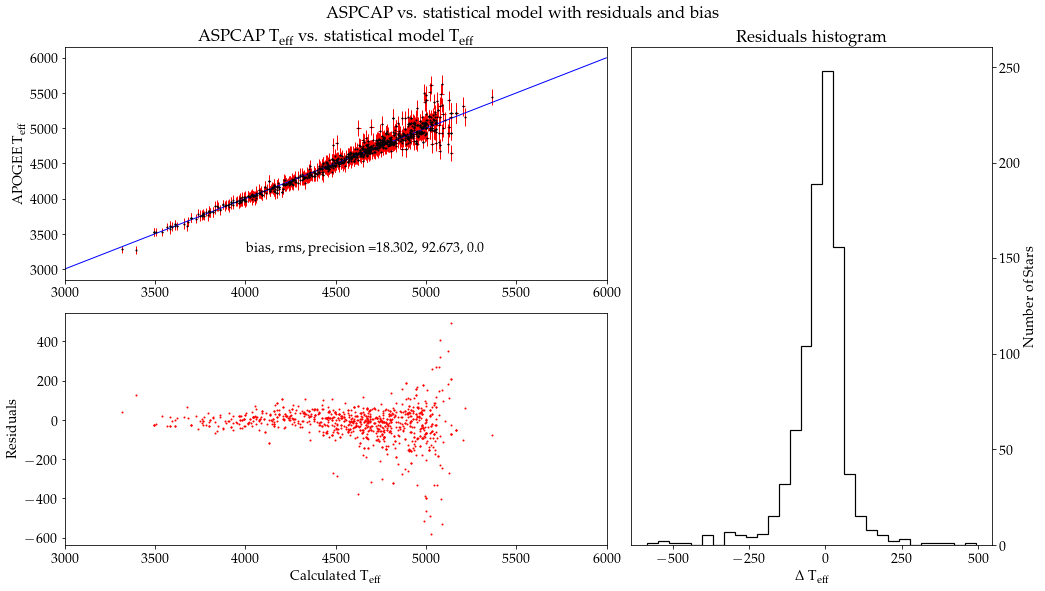

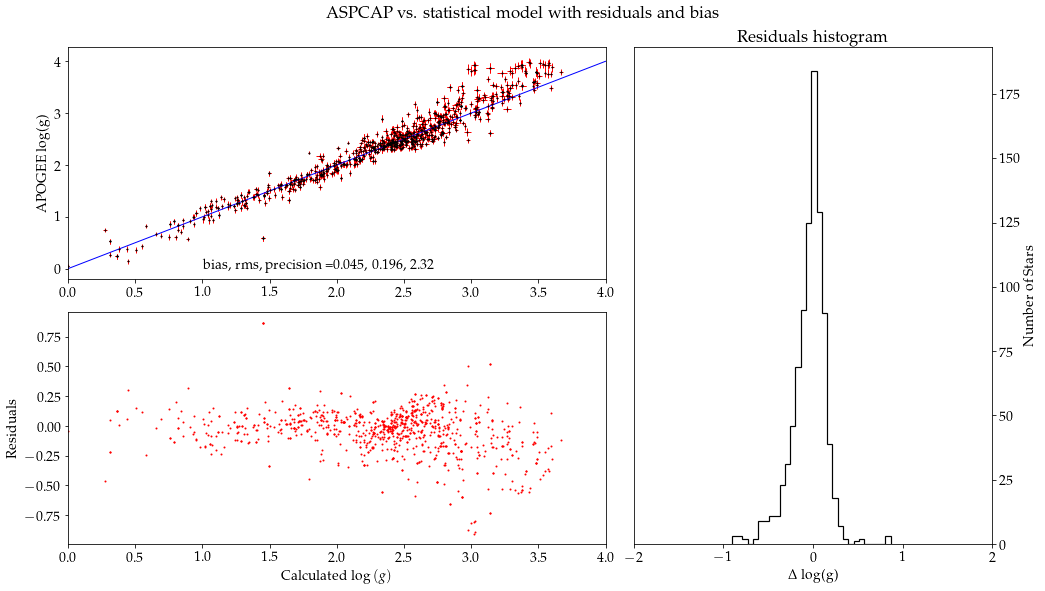

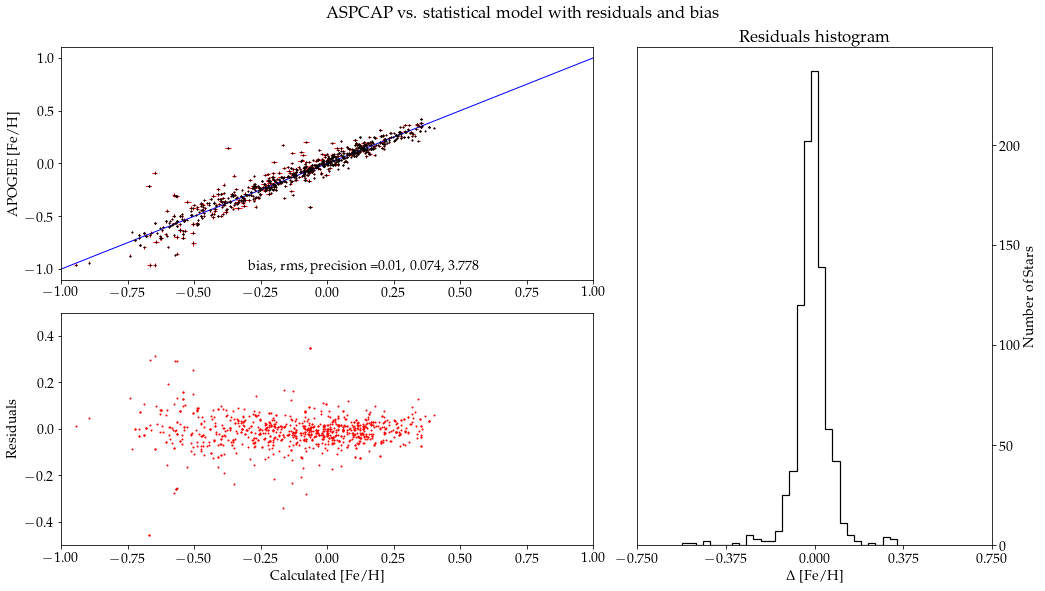

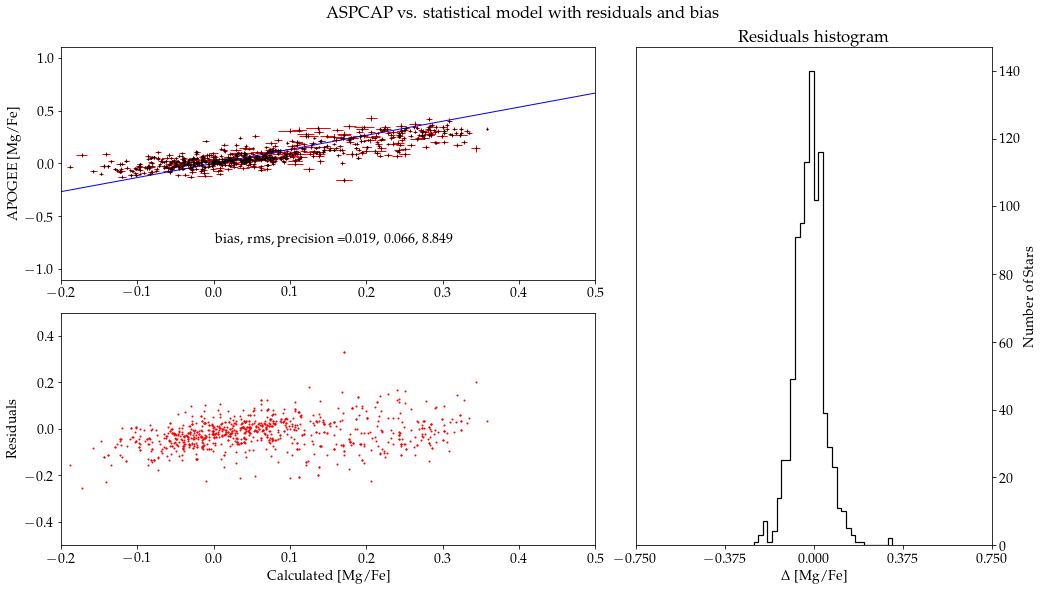

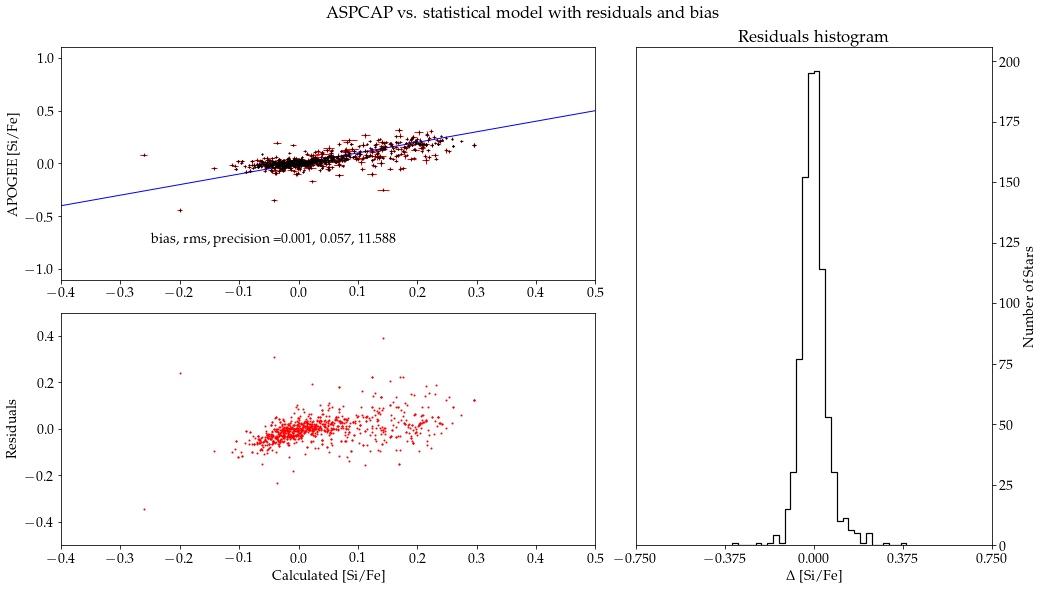

In [218]:
fig = plt.figure(constrained_layout=True)
rc("text", usetex=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

rc
ax1.scatter(teff_val, teff_arr, color='k', s=1.0, zorder=10.0)
ax1.errorbar(teff_val, teff_arr, yerr=teff_unc, xerr=teff_val_unc, fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(3000, 5999, 2), np.linspace(3000, 5999, 2), color='b', lw=1.0)
ax1.set_title('ASPCAP T$_{\\text{eff}}$ vs. statistical model T$_{\\text{eff}}$')
ax1.set_ylabel('APOGEE T$_{\\text{eff}}$')
ax1.set_xlim(3000,6000)
ax1.text(4000, 3250,f'bias, rms, precision ={teff_bias}, {teff_rms}, {teff_precision}')
ax2.scatter(teff_val, teff_res, color='r', s=1.0)
ax2.set_xlabel('Calculated T$_{\\text{eff}}$')
ax2.set_ylabel('Residuals')
ax3.hist(teff_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-500, 500, 5))
ax3.set_xlabel('$\Delta$ T$_{\\text{eff}}$')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.scatter(logg_val, logg_arr, color='k', s=1.0, zorder=10)
ax1.errorbar(logg_val, logg_arr, yerr=logg_unc, xerr=logg_val_unc, fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(0, 4, 2), np.linspace(0, 4, 2), color='b', lw=1.0)
ax1.set_xlim(0,4)
ax2.scatter(logg_val, logg_res, color='r', s=1.0)
ax1.text(1, 0,f'bias, rms, precision ={logg_bias}, {logg_rms}, {logg_precision}')
ax2.set_xlabel('Calculated $\log{(g)}$')
ax1.set_ylabel('APOGEE log(g)')
ax2.set_ylabel('Residuals')
ax3.hist(logg_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-2, 2, 5))
ax3.set_xlabel('$\\Delta$ log(g)')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.scatter(fe_h_val, fe_h_arr, color='k', s=1.0, zorder=10)
ax1.errorbar(fe_h_val, fe_h_arr, yerr=fe_h_unc, xerr=fe_h_val_unc, fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.text(-0.3, -1,f'bias, rms, precision ={fe_h_bias}, {fe_h_rms}, {fe_h_precision}')
ax1.set_xlim(-1,1)
ax2.scatter(fe_h_val, fe_h_res, color='r', s=1.0)
ax2.set_xlabel('Calculated [Fe/H]')
ax2.set_ylim(-0.5, 0.5)
ax1.set_ylabel('APOGEE [Fe/H]')
ax2.set_ylabel('Residuals')
ax3.hist(fe_h_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Fe/H]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.set_xlim(-0.2,0.5)
ax1.scatter(mg_fe_val, mg_fe_arr, color='k', s=1.0, zorder=10)
ax1.errorbar(mg_fe_val, mg_fe_arr, yerr=mg_fe_unc, xerr=mg_fe_val_unc, fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(-0.75, 0.75, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.text(0.0, -0.75,f'bias, rms, precision ={mg_fe_bias}, {mg_fe_rms}, {mg_fe_precision}')
ax2.scatter(mg_fe_val, mg_fe_res, color='r', s=1.0)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('Calculated [Mg/Fe]')
ax1.set_ylabel('APOGEE [Mg/Fe]')
ax2.set_ylabel('Residuals')
ax3.hist(mg_fe_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Mg/Fe]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.set_xlim(-0.4, 0.5)
ax1.scatter(si_fe_val, si_fe_arr, color='k', s=1.0, zorder=10)
ax1.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.errorbar(si_fe_val, si_fe_arr, yerr=si_fe_unc, xerr=si_fe_val_unc, fmt='none', lw=1.0, ecolor='r')
ax1.text(-0.25, -0.75,f'bias, rms, precision ={si_fe_bias}, {si_fe_rms}, {si_fe_precision}')
ax2.scatter(si_fe_val, si_fe_res, color='r', s=1.0)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('Calculated [Si/Fe]')
ax1.set_ylabel('APOGEE [Si/Fe]')
ax2.set_ylabel('Residuals')
ax3.hist(si_fe_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Si/Fe]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

# What went wrong?

Below we have collected the stars for which their residuals deviate more than $2.5\sigma$ from the mean of the residuals for that label. These stars are the pathological cases which skew our bias and rms (scatter) to much higher values than the rest of the data would indicate.

We can see that many stars have been flagged for persistence issues. According to [Holtzmann et al. 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aad4f9#ajaad4f9s3-1), persistence a phenomenon in which flux counts are boosted due to the previous exposure to other flux sources. This creates larger error in deriving what the stellar abundances are since it primarily affects the blue chip or the $15150-15800$ Angstrom range which is where a predominant number of the absorption lines for Mg and Si are. Since our model depended upon three separate stellar abundances and the ones given by APOGEE might not be correct, our model will have reduced accuracy when predicting the labels of these stars. Additionally, we see that many have been flagged for bright or very bright neighbors. These flags will affect the flux counts we receive from an individual star as flux noise. This noise affects the derivation of stellar parameters since it is not a constant noise due to the fact that each star has a flux that is non-constant with varying wavelength. Hence, we will be reading the sum of two fluxes which then increases the scatter which we calculated when training our model and thus also decreases the accuracy when predicting stellar labels.

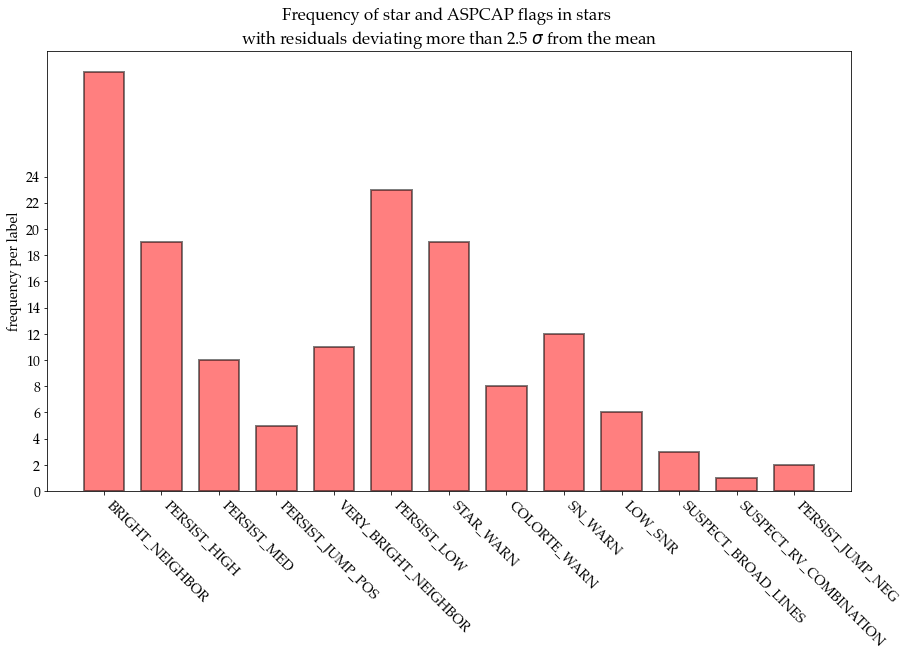

Text(0, 0.5, 'Frequency per bin')

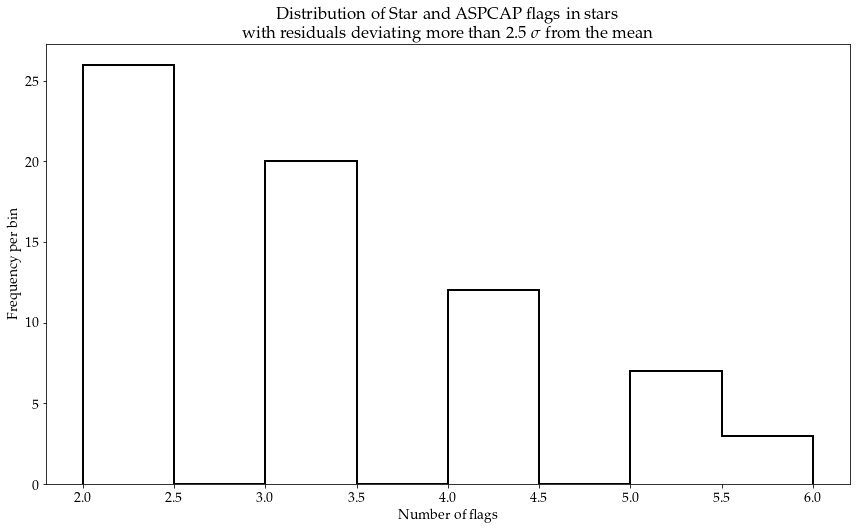

In [219]:
teff_avg = np.average(teff_res)
logg_avg = np.average(logg_res)
feh_avg = np.average(fe_h_res)
mgfe_avg = np.average(mg_fe_res)
sife_avg = np.average(si_fe_res)

teff_sd = np.std(teff_res)
logg_sd = np.std(logg_res)
feh_sd = np.std(fe_h_res)
mgfe_sd = np.std(mg_fe_res)
sife_sd = np.std(si_fe_res)

abnorm_teff = validation_set[np.where((teff_res < teff_avg-2.5*teff_sd) | (teff_res > teff_avg+2.5*teff_sd))[0]]
abnorm_logg = validation_set[np.where((logg_res < logg_avg-2.5*logg_sd) | (logg_res > logg_avg+2.5*logg_sd))[0]]
abnorm_feh = validation_set[np.where((fe_h_res < feh_avg-2.5*feh_sd) | (fe_h_res > feh_avg+2.5*feh_sd))[0]]
abnorm_mgfe = validation_set[np.where((mg_fe_res < mgfe_avg-2.5*mgfe_sd) | (mg_fe_res > mgfe_avg+2.5*mgfe_sd))[0]]
abnorm_sife = validation_set[np.where((si_fe_res < sife_avg-2.5*sife_sd) | (si_fe_res > sife_avg+2.5*sife_sd))[0]]

abnorm_stars = np.concatenate((abnorm_teff, abnorm_logg, abnorm_feh, abnorm_mgfe, abnorm_sife))

unique_inds = []

for i in range(len(abnorm_stars)):
    
    flag_bool=False
    
    for j in range(i+1, len(abnorm_stars)):
        
        if abnorm_stars[i]['teff'] == abnorm_stars[j]['teff']:
            
            flag_bool=True
            
    if flag_bool == False:
        
        unique_inds.append(i)
        
abnorm_stars = abnorm_stars[unique_inds]
abnorm_teff=[]
abnorm_logg=[]
abnorm_feh=[]
abn_teff_err=[]
abn_logg_err=[]
abn_feh_err=[]

abnorm_teff_2=[]
abnorm_logg_2=[]
abnorm_feh_2=[]

for star in abnorm_stars:
    
    abnorm_teff.append(star['allStar_misc']['teff'])
    abnorm_logg.append(star['allStar_misc']['logg'])
    abnorm_feh.append(star['allStar_misc']['fe_h'])
    abn_teff_err.append(star['allStar_misc']['teff_err'])
    abn_logg_err.append(star['allStar_misc']['logg_err'])
    abn_feh_err.append(star['allStar_misc']['m_h_err'])
    abnorm_teff_2.append(star['ell_validation'][0]*5700)
    abnorm_logg_2.append(star['ell_validation'][1]*4)
    abnorm_feh_2.append(star['ell_validation'][2])

flag_dict = {}
star_flag_ct = []

for i in range(len(abnorm_stars)):
    
    star_flags = abnorm_stars[i]['allStar_misc']['starflags'].split(',')
    aspcap_flags = abnorm_stars[i]['allStar_misc']['aspcapflags'].split(',')
    star_flag_ct.append(len(star_flags)+len(aspcap_flags))
    abnorm_flags = star_flags+aspcap_flags
    
    for flag in abnorm_flags:
        
        if flag in flag_dict:
            
            flag_dict[flag]+=1
            
        else:
            
            flag_dict[flag]=1

from matplotlib import rc
rc("text", usetex=False)
keys = list(flag_dict.keys())
vals = list(flag_dict.values())

for i in range(len(keys)):
    
    if keys[i] == '':
        
        keys = keys[:i]+keys[i+1:]
        vals = vals[:i]+vals[i+1:]
        break
        
plt.bar(keys, vals, edgecolor='k', lw=2.0, facecolor='r', alpha=0.5, width=0.7)
plt.xticks(rotation=-45, ha='left')
plt.yticks(np.linspace(0, 24, 13))
plt.ylabel('frequency per label')
plt.title('Frequency of star and ASPCAP flags in stars \nwith residuals deviating more than 2.5 $\sigma$ from the mean')
plt.show()

rc("text", usetex=True)
plt.hist(star_flag_ct, bins=8, histtype='step', color='k', lw=2.0)
plt.title('Distribution of Star and ASPCAP flags in stars \nwith residuals deviating more than 2.5 $\sigma$ from the mean')
plt.xlabel('Number of flags')
plt.ylabel('Frequency per bin')

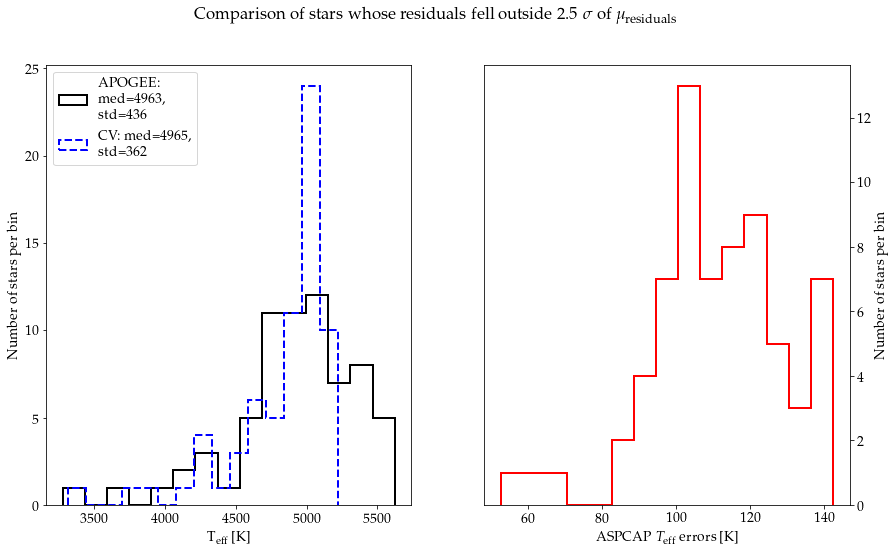

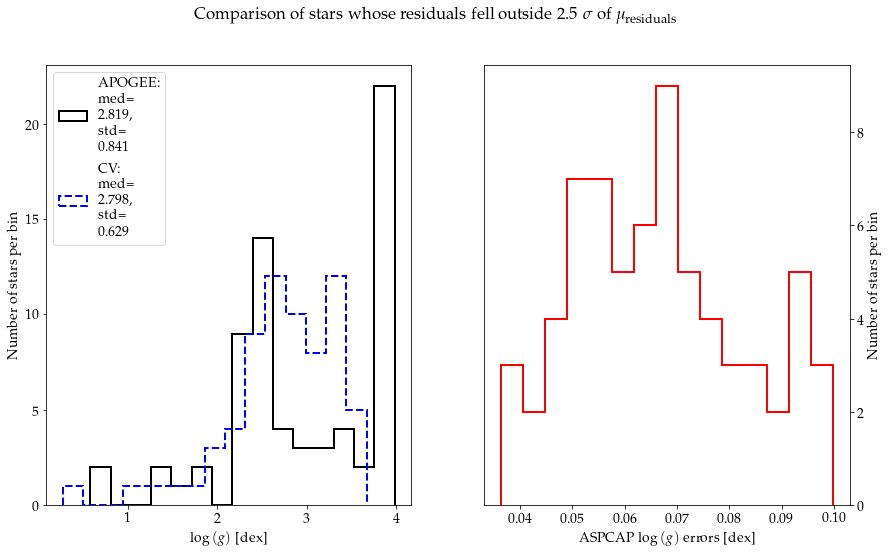

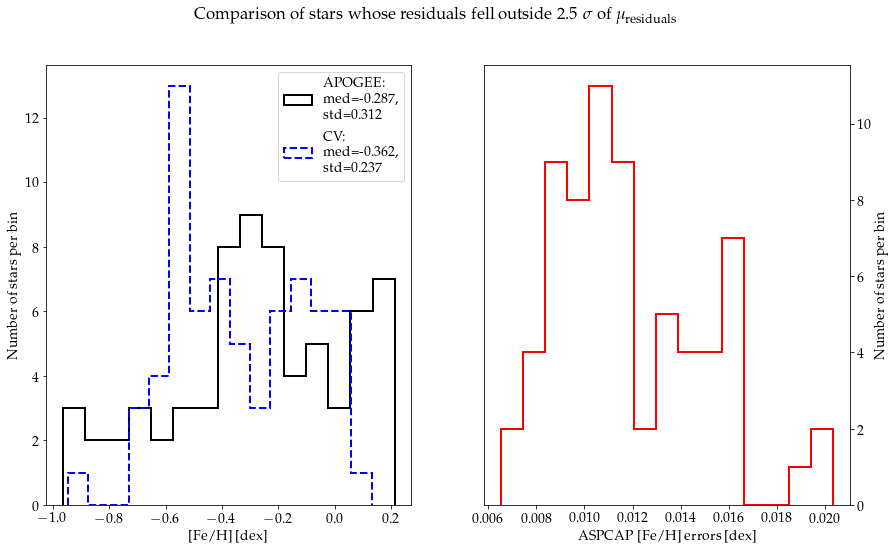

In [220]:
fig, ax = plt.subplots(1, 2)
    
ax[0].hist(abnorm_teff, bins=15, histtype='step', color='k', lw=2.0,
         label=f'APOGEE: \nmed={(np.median(abnorm_teff)):.0f},\nstd={np.std((abnorm_teff)):.0f}')
ax[0].hist(abnorm_teff_2, bins=15, histtype='step', ls='--', color='b', lw=2.0,
        label=f'CV: med={(np.median((abnorm_teff_2))):.0f},\nstd={(np.std(abnorm_teff_2)):.0f}')
ax[0].set_xlabel('T$_{\\text{eff}}$ [K]')
ax[0].set_ylabel('Number of stars per bin')
fig.suptitle('Comparison of stars whose residuals fell outside 2.5 $\sigma$ of $\mu_{\\text{residuals}}$')
ax[0].legend(loc='upper left')
ax[1].hist(abn_teff_err, bins=15, histtype='step', color='r', lw=2.0)
ax[1].set_xlabel('ASPCAP $T_{\\text{eff}}$ errors [K]')
ax[1].set_ylabel('Number of stars per bin')
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
plt.show()

fig, ax = plt.subplots(1, 2)

ax[0].hist(abnorm_logg, bins=15, histtype='step', color='k', lw=2.0,
         label=f'APOGEE: \nmed=\n{np.median(abnorm_logg):.3f},\nstd=\n{np.std(abnorm_logg):.3f}')
ax[0].hist(abnorm_logg_2, bins=15, histtype='step', ls='--', color='b', lw=2.0,
        label=f'CV: \nmed=\n{np.median(abnorm_logg_2):.3f},\nstd=\n{np.std(abnorm_logg_2):.3f}')
ax[0].legend(loc='upper left')
ax[0].set_xlabel('$\log{(g)}$ [dex]')
ax[0].set_ylabel('Number of stars per bin')
fig.suptitle('Comparison of stars whose residuals fell outside 2.5 $\sigma$ of $\mu_{\\text{residuals}}$')
ax[1].hist(abn_logg_err, bins=15, histtype='step', color='r', lw=2.0)
ax[1].set_xlabel('ASPCAP $\\log{(g)}$ errors [dex]')
ax[1].set_ylabel('Number of stars per bin')
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
plt.show()

fig, ax = plt.subplots(1, 2)
ax[0].hist(abnorm_feh, bins=15, histtype='step', color='k', lw=2.0,
         label=f'APOGEE: \nmed={np.median(abnorm_feh):.3f},\nstd={np.std(abnorm_feh):.3f}')
ax[0].hist(abnorm_feh_2, bins=15, histtype='step', ls='--', color='b', lw=2.0,
        label=f'CV: \nmed={np.median(abnorm_feh_2):.3f},\nstd={np.std(abnorm_feh_2):.3f}')
ax[0].set_xlabel('[Fe/H] [dex]')
ax[0].set_ylabel('Number of stars per bin')
fig.suptitle('Comparison of stars whose residuals fell outside 2.5 $\sigma$ of $\mu_{\\text{residuals}}$')
ax[1].hist(abn_feh_err, bins=15, histtype='step', color='r', lw=2.0)
ax[1].set_xlabel('ASPCAP [Fe/H] errors [dex]')
ax[1].set_ylabel('Number of stars per bin')
ax[0].legend(loc='upper right')
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
plt.show()

We see that after removing these stars from our data, we see a large decrease in the T$_{\text{eff}}$, $\log{(\text{g})}$ and $[\text{Fe}/\text{H}]$ scatter. Our model appears to work as is intended and we can rely on it to predict within reasonable error what the labels for a given star are. We recommend in the future that stars should be analyzed first according to their flags before being partitioned into training and cross-validation sets. Additionally, it would be worth it to investigate how the statistical model performs when a k-fold Cross-validation is performed instead to determine how much of an effect these flags actually make across the entire population of stars. Moreover, we also conclude on the note that there is heteroskedasticity present in our validation stars even after removing the ones with high residuals. We know that our model is imperfect and so we have heteroskedasticity present. We can see this especially in the temperature: as the temperature increases, so does the average value of the absolute value of the residuals. Our model does not take into account enough labels which the APOGEE model does take into account such as abundances of other elements, rotation, and so on and so forth. For the future, we recommend that a model with a greater number of parameters be employed to reduce the variance in the residuals with increasing label values. It could also be the case that our model did not train on enough stars with higher temperature values and so was unable to extrapolate correctly based upon how it was trained to determine the labels at such temperature values. We can see from our corner plot above that most of the stars lie within the region $[3500\text{K}, 5000\text{K}]$ which would make our model more accurate in that region and less accurate in the higher temperature region.

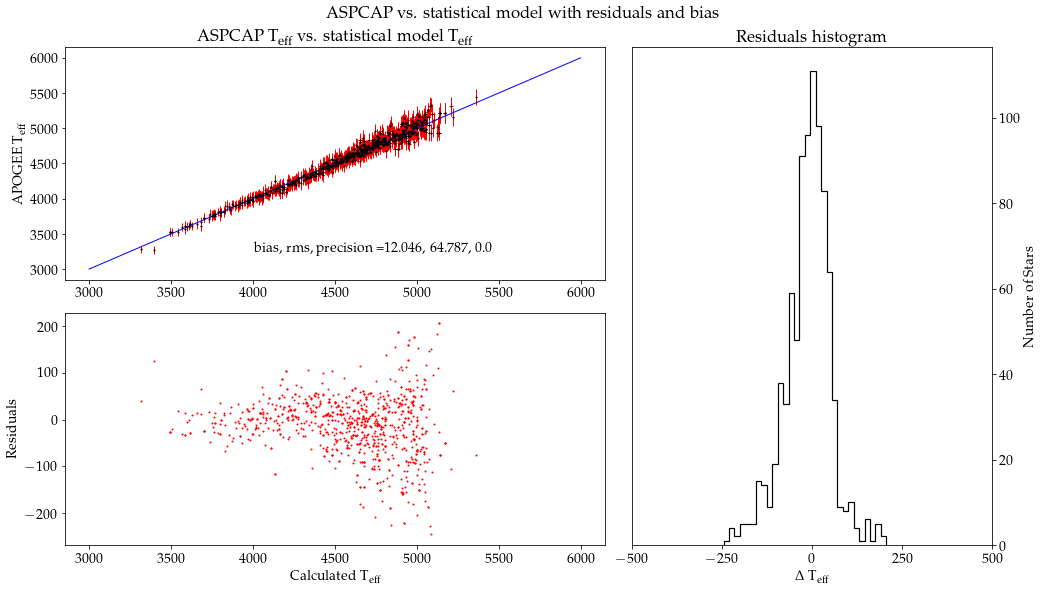

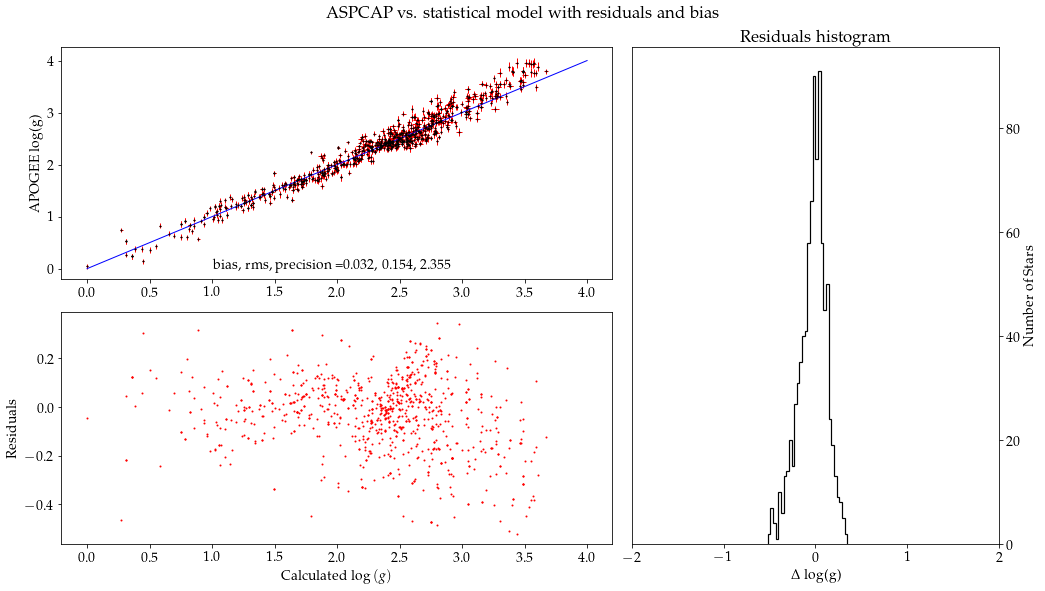

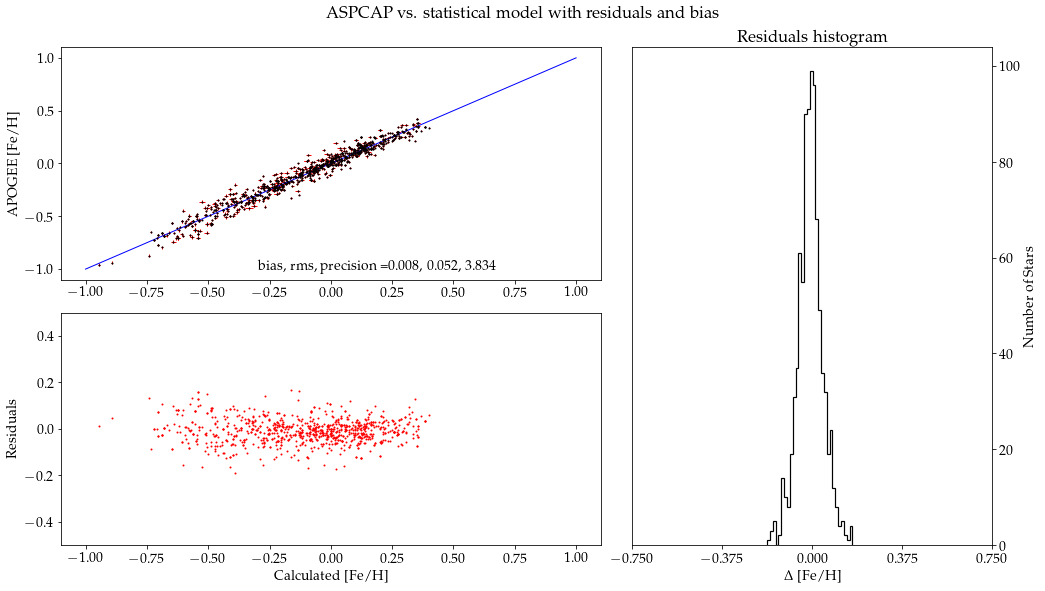

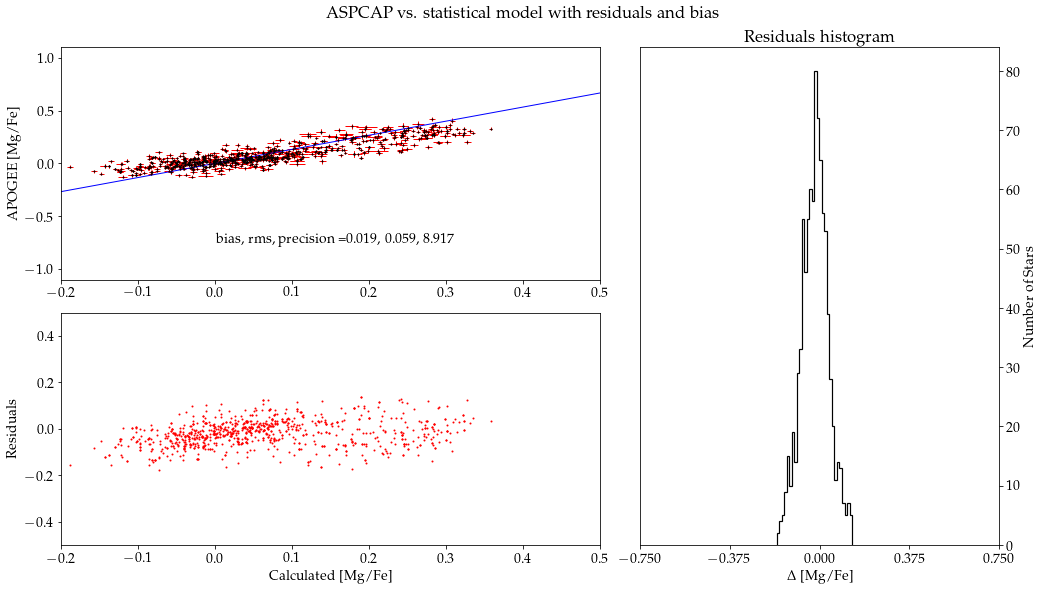

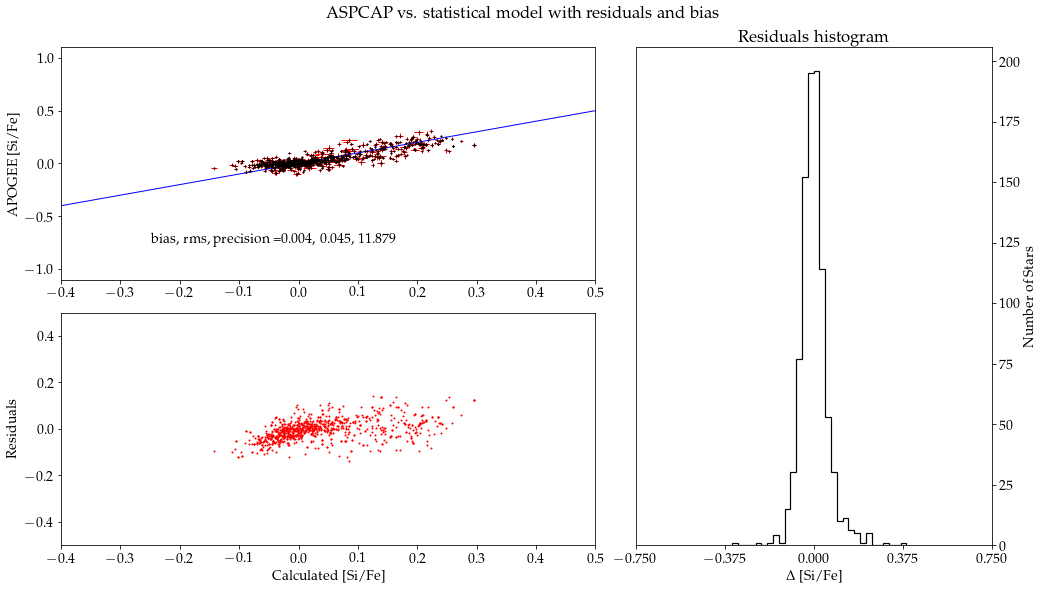

In [221]:
teff_avg = np.average(teff_res)
teff_sd = np.std(teff_res)
logg_avg = np.average(logg_res)
logg_sd = np.std(logg_res)
feh_avg = np.average(fe_h_res)
feh_sd = np.std(fe_h_res)
mgfe_avg = np.average(mg_fe_res)
mgfe_sd = np.std(mg_fe_res)
sife_avg = np.average(si_fe_res)
sife_sd = np.std(si_fe_res)

good_teff_inds = np.where((teff_res > teff_avg-2.5*teff_sd) & (teff_res < teff_avg+2.5*teff_sd))[0]
good_logg_inds = np.where((logg_res > logg_avg-2.5*logg_sd) & (logg_res < logg_avg+2.5*logg_sd))[0]
good_fe_h_inds = np.where((fe_h_res > feh_avg-2.5*feh_sd) & (fe_h_res < feh_avg+2.5*feh_sd))[0]
good_mg_fe_inds = np.where((mg_fe_res > mgfe_avg-2.5*mgfe_sd) & (mg_fe_res < mgfe_avg+2.5*mgfe_sd))[0]
good_si_fe_inds = np.where((si_fe_res > sife_avg-2.5*sife_sd) & (si_fe_res < sife_avg+2.5*sife_sd))[0]

teff_val_2 = teff_val[good_teff_inds]
logg_val_2 = logg_val[good_logg_inds]
fe_h_val_2 = fe_h_val[good_fe_h_inds]
mg_fe_val_2 = mg_fe_val[good_mg_fe_inds]
si_fe_val_2 = si_fe_val[good_si_fe_inds]

teff_arr_2 = teff_arr[good_teff_inds]
logg_arr_2 = logg_arr[good_logg_inds]
fe_h_arr_2 = fe_h_arr[good_fe_h_inds]
mg_fe_arr_2 = mg_fe_arr[good_mg_fe_inds]
si_fe_arr_2 = si_fe_arr[good_si_fe_inds]

teff_res_2 = np.array(teff_val_2)-np.array(teff_arr_2)
logg_res_2 = np.array(logg_val_2)-np.array(logg_arr_2)
fe_h_res_2 = np.array(fe_h_val_2)-np.array(fe_h_arr_2)
mg_fe_res_2 = np.array(mg_fe_val_2)-np.array(mg_fe_arr_2)
si_fe_res_2 = np.array(si_fe_val_2)-np.array(si_fe_arr_2)

teff_bias = int((np.average(np.array(teff_arr_2))-np.average(np.array(teff_val_2)))*10**3)/10**3
logg_bias = int((np.average(np.array(logg_arr_2))-np.average(np.array(logg_val_2)))*10**3)/10**3
fe_h_bias = int((np.average(np.array(fe_h_arr_2))-np.average(np.array(fe_h_val_2)))*10**3)/10**3
mg_fe_bias = int((np.average(np.array(mg_fe_arr_2))-np.average(np.array(mg_fe_val_2)))*10**3)/10**3
si_fe_bias = int((np.average(np.array(si_fe_arr_2))-np.average(np.array(si_fe_val_2)))*10**3)/10**3

teff_rms = int(np.sqrt(np.sum(teff_res_2**2)/len(teff_res_2))*10**3)/10**3
logg_rms = int(np.sqrt(np.sum(logg_res_2**2)/len(logg_res_2))*10**3)/10**3
fe_h_rms = int(np.sqrt(np.sum(fe_h_res_2**2)/len(fe_h_res_2))*10**3)/10**3
mg_fe_rms = int(np.sqrt(np.sum(mg_fe_res_2**2)/len(mg_fe_res_2))*10**3)/10**3
si_fe_rms = int(np.sqrt(np.sum(si_fe_res_2**2)/len(si_fe_res_2))*10**3)/10**3


teff_precision = int(1/(np.std(teff_val_2)**2)*10**3)/10**3
logg_precision = int((1/np.std(logg_val_2)**2)*10**3)/10**3
fe_h_precision = int((1/np.std(fe_h_val_2))*10**3)/10**3
mg_fe_precision = int((1/np.std(mg_fe_val_2))*10**3)/10**3
si_fe_precision = int((1/np.std(si_fe_val_2))*10**3)/10**3

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.scatter(teff_val[good_teff_inds], teff_arr[good_teff_inds], color='k', s=1.0, zorder=10.0)
ax1.errorbar(teff_val[good_teff_inds], teff_arr[good_teff_inds], yerr=teff_unc[good_teff_inds],
             xerr=teff_val_unc[good_teff_inds], fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(3000, 5999, 2), np.linspace(3000, 5999, 2), color='b', lw=1.0)
ax1.set_title('ASPCAP T$_{\\text{eff}}$ vs. statistical model T$_{\\text{eff}}$')
ax1.set_ylabel('APOGEE T$_{\\text{eff}}$')
ax1.text(4000, 3250,f'bias, rms, precision ={teff_bias}, {teff_rms}, {teff_precision}')
ax2.scatter(teff_val_2, teff_res_2, color='r', s=1.0)
ax2.set_xlabel('Calculated T$_{\\text{eff}}$')
ax2.set_ylabel('Residuals')
ax3.hist(teff_res_2, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-500, 500, 5))
ax3.set_xlabel('$\\Delta$ T$_{\\text{eff}}$')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.scatter(logg_val_2, logg_arr_2, color='k', s=1.0, zorder=10)
ax1.errorbar(logg_val_2, logg_arr_2, yerr=logg_unc[good_logg_inds], xerr=logg_val_unc[good_logg_inds],
             fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(0, 4, 2), np.linspace(0, 4, 2), color='b', lw=1.0)
ax2.scatter(logg_val_2, logg_res_2, color='r', s=1.0)
ax1.text(1, 0,f'bias, rms, precision ={logg_bias}, {logg_rms}, {logg_precision}')
ax2.set_xlabel('Calculated $\log{(g)}$')
ax1.set_ylabel('APOGEE log(g)')
ax2.set_ylabel('Residuals')
ax3.hist(logg_res_2, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-2, 2, 5))
ax3.set_xlabel('$\\Delta$ log(g)')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.scatter(fe_h_val_2, fe_h_arr_2, color='k', s=1.0, zorder=10)
ax1.errorbar(fe_h_val_2, fe_h_arr_2, yerr=fe_h_unc[good_fe_h_inds], xerr=fe_h_val_unc[good_fe_h_inds],
             fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.text(-0.3, -1,f'bias, rms, precision ={fe_h_bias}, {fe_h_rms}, {fe_h_precision}')
ax2.scatter(fe_h_val_2, fe_h_res_2, color='r', s=1.0)
ax2.set_xlabel('Calculated [Fe/H]')
ax2.set_ylim(-0.5, 0.5)
ax1.set_ylabel('APOGEE [Fe/H]')
ax2.set_ylabel('Residuals')
ax3.hist(fe_h_res_2, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Fe/H]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.set_xlim(-0.2,0.5)
ax1.scatter(mg_fe_val_2, mg_fe_arr_2, color='k', s=1.0, zorder=10)
ax1.errorbar(mg_fe_val_2, mg_fe_arr_2, yerr=mg_fe_unc[good_mg_fe_inds], xerr=mg_fe_val_unc[good_mg_fe_inds],
             fmt='none', lw=1.0, ecolor='r')
ax1.plot(np.linspace(-0.75, 0.75, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.text(0.0, -0.75,f'bias, rms, precision ={mg_fe_bias}, {mg_fe_rms}, {mg_fe_precision}')
ax2.scatter(mg_fe_val_2, mg_fe_res_2, color='r', s=1.0)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('Calculated [Mg/Fe]')
ax1.set_ylabel('APOGEE [Mg/Fe]')
ax2.set_ylabel('Residuals')
ax3.hist(mg_fe_res_2, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Mg/Fe]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[:,1])

ax1.set_xlim(-0.4, 0.5)
ax1.scatter(si_fe_val_2, si_fe_arr_2, color='k', s=1.0, zorder=10)
ax1.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color='b', lw=1.0)
ax1.errorbar(si_fe_val_2, si_fe_arr_2, yerr=si_fe_unc[good_si_fe_inds], xerr=si_fe_val_unc[good_si_fe_inds],
             fmt='none', lw=1.0, ecolor='r')
ax1.text(-0.25, -0.75,f'bias, rms, precision ={si_fe_bias}, {si_fe_rms}, {si_fe_precision}')
ax2.scatter(si_fe_val_2, si_fe_res_2, color='r', s=1.0)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('Calculated [Si/Fe]')
ax1.set_ylabel('APOGEE [Si/Fe]')
ax2.set_ylabel('Residuals')
ax3.hist(si_fe_res, bins=30, histtype='step', color='k', lw=1.2)
ax3.yaxis.tick_right()
ax3.set_xticks(np.linspace(-0.75, 0.75, 5))
ax3.set_xlabel('$\\Delta$ [Si/Fe]')
ax3.set_title('Residuals histogram')
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Number of Stars')
fig.suptitle('ASPCAP vs. statistical model with residuals and bias')
plt.show()

# Iron Trends

Below we have plotted a Kiel Diagram where we have set the axes inverted so that temperature increases with motion to the left and the log of the gravitational acceleration increases with motion downwards. Additionally, we have colored the points by their [Fe/H] concentration. We can see immediately that as one decreases $\log{(\text{g})}$ while holding temperature fixed that [Fe/H] increases from negative to positive values. Additionally, we see that approximately $4700 \text{ K}$ that the one line splits into two separate branches. According to [Holtzman et al. 2015](https://arxiv.org/pdf/1501.04110.pdf), this branching may be due to stars belong to two different age groups and so one isochrone does not fit both groupings of stars well.

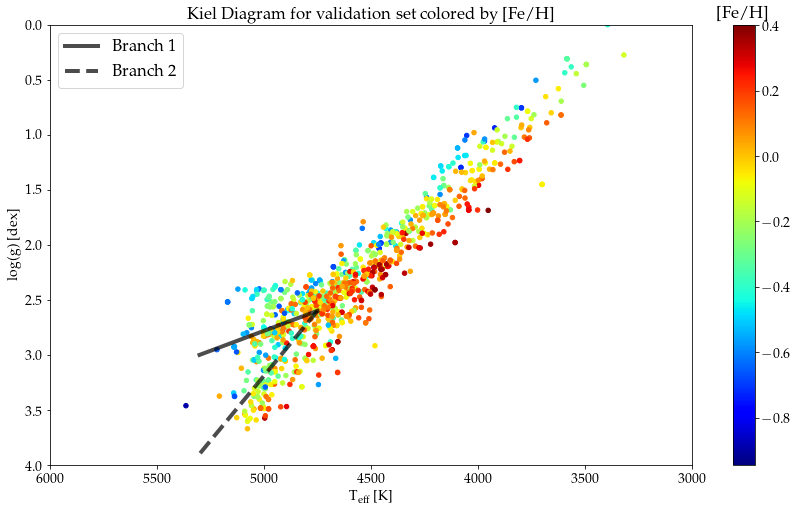

In [257]:
plt.scatter(teff_val, logg_val, c=fe_h_val, cmap='jet', s=20.0)
plt.ylabel('log(g) [dex]')
plt.xlabel('T$_{\\text{eff}}$ [K]')
plt.title('Kiel Diagram for validation set colored by [Fe/H]')
plt.plot(np.linspace(4750, 5300, 2), np.linspace(2.6, 3.0, 2), color='k', lw=4.0, alpha=0.7,
        label='Branch 1')
plt.plot(np.linspace(4750, 5300, 2), np.linspace(2.6, 3.9, 2), color='k', ls='--',lw=4.0, alpha=0.7,
        label='Branch 2')
plt.legend(fontsize='large')
plt.xlim(6000, 3000)
plt.ylim(4, 0)
clb = plt.colorbar()
clb.ax.set_title('[Fe/H]')
plt.show()

In [223]:
iso2 = read_mist_models.ISO('MIST_iso_6070ec091d737.iso')
age_ind2 = iso2.age_index(6000000000.000014)
solar_abund_iso = read_mist_models.ISO('MIST_iso_6070ec1e8bd79.iso')
age_ind = solar_abund_iso.age_index(6000000000.000014)

Reading in: MIST_iso_6070ec091d737.iso
Reading in: MIST_iso_6070ec1e8bd79.iso


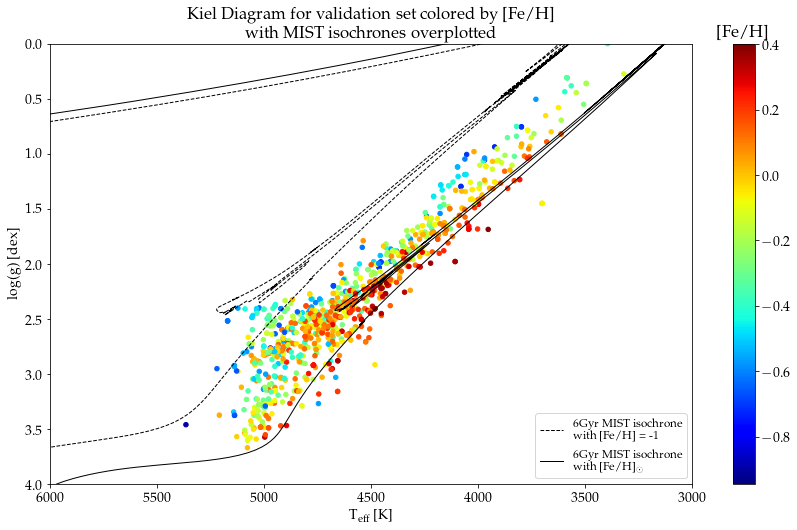

In [224]:
logg = solar_abund_iso.isos[age_ind]['log_g']
teff = 10**(solar_abund_iso.isos[age_ind]['log_Teff'])

logg2 = iso2.isos[age_ind2]['log_g']
teff2 = 10**(iso2.isos[age_ind2]['log_Teff'])

plt.plot(teff, logg, color='k', lw=1.0, linestyle='--', label='6Gyr MIST isochrone \nwith [Fe/H] = -1')
plt.plot(teff2, logg2, color='k', lw=1.0, label='6Gyr MIST isochrone \nwith [Fe/H]$_{\odot}$')
plt.scatter(teff_val, logg_val, c=fe_h_val, cmap='jet', s=20.0)
plt.xlim(6000, 3000)
plt.ylim(4, 0)
plt.ylabel('log(g) [dex]')
plt.xlabel('T$_{\\text{eff}}$ [K]')
plt.title('Kiel Diagram for validation set colored by [Fe/H] \nwith MIST isochrones overplotted')
clb = plt.colorbar()
clb.ax.set_title('[Fe/H]')
plt.legend(fontsize='small')
plt.show()

In [225]:
hdul = fits.open('mystery_spec_wiped.fits')

spectrum = hdul[1].data
errors = hdul[2].data
bitmask = hdul[3].data

#initialize lists to be stored
spec_l = []
spec_m = []
spec_h = []

errs_l = []
errs_m = []
errs_h = []

#adjust the errors based on bitmasks
errors = pixel_checker(errors, bitmask)

for i in range(len(wavelength)):

    if 15150 < wavelength[i] < 15800:

        spec_l.append(spectrum[i])
        errs_l.append(errors[i])

    if 15890 < wavelength[i] < 16430:

        spec_m.append(spectrum[i])
        errs_m.append(errors[i])

    if 16490 < wavelength[i] < 16950:

        spec_h.append(spectrum[i])
        errs_h.append(errors[i])

#fit the continuum spectra and normalize
norm_l = normed_spectra(wl_l[ind_l], np.array(spec_l)[ind_l], np.array(errs_l)[ind_l], spec_l, errs_l, wl_l)
norm_m = normed_spectra(wl_m[ind_m], np.array(spec_m)[ind_m], np.array(errs_m)[ind_m], spec_m, errs_m, wl_m)
norm_h = normed_spectra(wl_h[ind_h], np.array(spec_h)[ind_h], np.array(errs_h)[ind_h], spec_h, errs_h, wl_h)

#create new spectrum and errors lists
norm_spectrum = np.array(norm_l[0]+norm_m[0]+norm_h[0])
norm_errors = np.array(norm_l[1]+norm_m[1]+norm_h[1])
wavelength = np.concatenate((wl_l,wl_m,wl_h))
norm_errors = np.sqrt(norm_errors**2+np.array(err_arr)**2)

# PyMC3 Approach

We now try a PyMC3 approach to determining the labels of a mystery spectrum. We do this to compare it to our optimization model which works based off of a least squares approach whereas PyMC3 works via a probabilistic or Bayesian approach. We approach the problem similarly to our optimization problem: we have known flux values at various wavelengths and attempt to determine the stellar labels from these wavelengths by using our known $\theta$ and $s_{\lambda}^2$ values we obtained from our training step.

We have no prior knowledge of what star might emit this kind of spectrum, but we do know that our model has exceptionally weak extrapolative power yet strong interpolative power and so we use improper priors yet uniform priors:

$$
T_{\text{eff}} = \frac{1}{\sqrt{2\sigma_T^2}}\exp{\left(\frac{(T-\mu_T)^2}{2\sigma_T^2}\right)},
$$

$$
\log{(\text{g})} = \frac{1}{\sqrt{2\sigma_g^2}}\exp{\left(\frac{(\log{(g)}-\mu_g)^2}{2\sigma_g^2}\right)},
$$

$$
[Fe/H] = \frac{1}{\sqrt{2\sigma_{Fe}^2}}\exp{\left(\frac{([Fe/H]-\mu_{Fe})^2}{2\sigma_{Fe}^2}\right)},
$$

$$
[Mg/Fe] = \frac{1}{\sqrt{2\sigma_{Mg}^2}}\exp{\left(\frac{([Mg/Fe]-\mu_{Mg})^2}{2\sigma_{Mg}^2}\right)},
$$

$$
[Si/Fe] = \frac{1}{\sqrt{2\sigma_{Si}^2}}\exp{\left(\frac{([Si/Fe]-\mu_{Si})^2}{2\sigma_{Si}^2}\right)}
$$

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
INFO:pymc3:Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (4 chains in 1 job)
INFO:pymc3:Sequential sampling (4 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Slice: [[Si/Fe]]
INFO:pymc3:>Slice: [[Si/Fe]]
>Slice: [[Mg/Fe]]
INFO:pymc3:>Slice: [[Mg/Fe]]
>Slice: [[Fe/H]]
INFO:pymc3:>Slice: [[Fe/H]]
>Slice: [$\log{(\text{g})}$]
INFO:pymc3:>Slice: [$\log{(\text{g})}$]
>Slice: [T$_{\text{eff}}$]
INFO:pymc3:>Slice: [T$_{\text{eff}}$]


Sampling 4 chains for 1_500 tune and 4_000 draw iterations (6_000 + 16_000 draws total) took 146 seconds.
INFO:pymc3:Sampling 4 chains for 1_500 tune and 4_000 draw iterations (6_000 + 16_000 draws total) took 146 seconds.
The number of effective samples is smaller than 10% for some parameters.


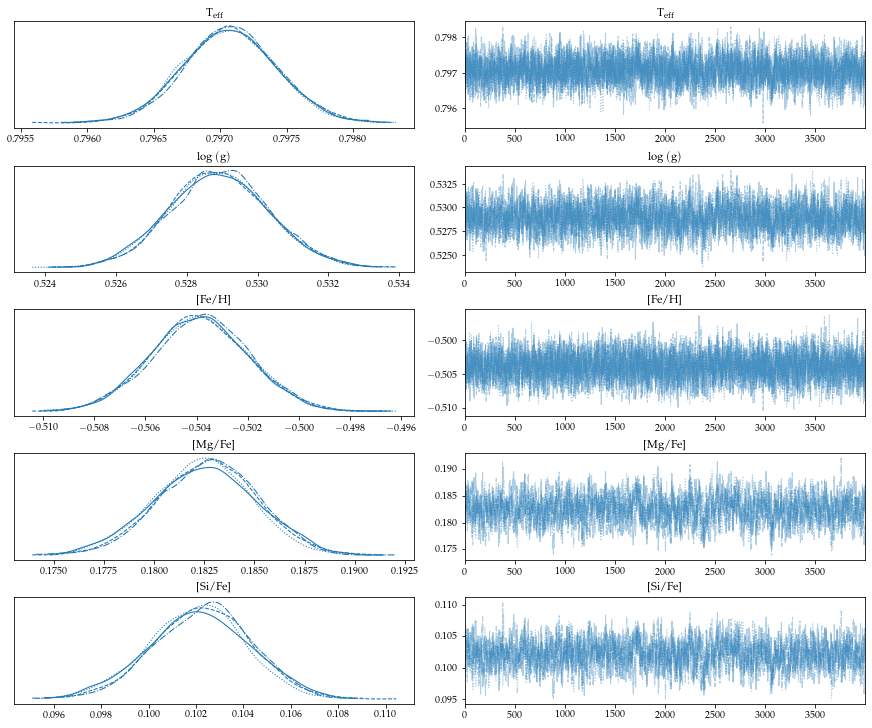

In [227]:
labels_model = pm.Model()

logl = LogLike(my_logllh, norm_spectrum, theta_arr, norm_errors)

ndraws = 4000
nburn = 1500

with labels_model:

    # Priors for unknown model parameters
    teff = pm.Normal('T$_{\\text{eff}}$', mu=0.8, sd=1.5)
    logg = pm.Normal('$\\log{(\\text{g})}$', mu=0.5, sd=0.5)
    fe_h = pm.Normal('[Fe/H]', mu=-0.2, sd=0.1)
    mg_fe = pm.Normal('[Mg/Fe]', mu=0.0, sd=0.1)
    si_fe = pm.Normal('[Si/Fe]', mu=0.0, sd=0.1)
    
    params=tt.as_tensor_variable([teff, logg, fe_h, mg_fe, si_fe])

    # use a Potential distribution to call the likelihood function
    pm.Potential('likelihood', logl(params))
    
    # draw ndraws posterior samples
    trace = pm.sample(ndraws, tune=nburn, chains=4, cores=1, discard_tuned_samples=True, 
                      return_inferencedata=False)
    
    az.summary(trace)

    traceplot(trace)

# PyMC3 Analysis of mystery spectrum

We can see that our sampler converged on values without much uncertainty as to how accurate those values are. Compared to the ASPCAP values, these are exceptionally small values and so they warrant scrutiny especially since our calculated labels for the cross-validation set had small uncertainties as well despite having high residuals for some of the labels. Since the sampler steps through parameter space and attempts to find a global minimum, we see that if it is highly certain that it has found a global minimum then it must think that the values around the supposed minimum must decrease the log-likelihood. Hence, our likelihood calculation could be a source of error. We only provided our scatter values and the uncertainties given to us in the ASPCAP data. We only concerned ourselves with certain bitmasks when determining which errors we should increase to weight the pixels appropriately. Additionally, our calculated scatter values may be poorly calculated thus giving us poor likelihood values. Lastly, our model that we are using to calculate the flux values may be inaccurate which is thus giving us values which would affect the likelihood calculation. Specifically, we should expect higher uncertainties when we see that multiple combinations of labels could apply to the data and so if we have too simplistic of a model, the likelihood function would not take that into account and would thus return high likelihoods for parameters which are not actually close to the real values and would see those values as being close with little uncertainty.

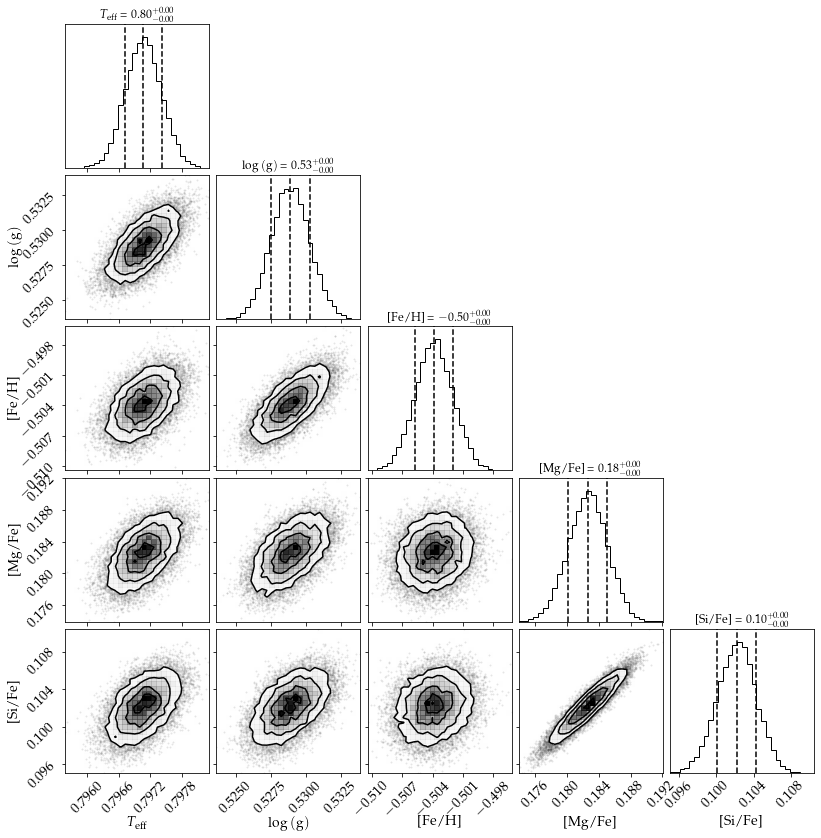

In [228]:
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples, labels=[r"$T_{\text{eff}}$", r"$\log{(\text{g})}$", r"[Fe/H]", r"[Mg/Fe]", r"[Si/Fe]"],
                  bins=30,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

# PyMC3 vs. Optimization

We can see that our predicted values from the optimization and PyMC3 are nearly identical. This doesn't necessarily validate our model as being accurate but it does give a cross-validation. For our model to be accurate, it must be scrutinized by other means since our probabilistic approach still used the same model that we used for our validation step and the same log-likelihood. Additionally, we could try other priors to determine how PyMC3 varies with a prior variation.

In [275]:
popt,pcov = optimize.curve_fit(model, np.array(theta_arr), norm_spectrum, method='trf',
                    sigma=np.sqrt(np.array(err_arr)+np.array(norm_errors)**2),
                    p0=avgs,
                    bounds=([3000/5700, 0, -1, -1, -1],
                            [6000/5700, 1, 4, 4, 4]), tr_solver='exact',diff_step=0.015, max_nfev=1000000)

print(f'Predicted temperature is {popt[0]*5700:.0f} K.')
print(f'Predicted logg is {popt[1]*4:.3f} dex')
print(f'Predicted [Fe/H] is {popt[2]:.3f} dex.')
print(f'Predicted [Mg/Fe] is {popt[3]:.3f} dex.')
print(f'Predicted [Si/Fe] is {popt[4]:.3f} dex.')

Predicted temperature is 4565 K.
Predicted logg is 2.129 dex
Predicted [Fe/H] is -0.490 dex.
Predicted [Mg/Fe] is 0.175 dex.
Predicted [Si/Fe] is 0.100 dex.


In [229]:
teff = samples['T$_{\\text{eff}}$']
logg = samples['$\\log{(\\text{g})}$']
fe_h = samples['[Fe/H]']
mg_fe = samples['[Mg/Fe]']
si_fe = samples['[Si/Fe]']

print(f'The fitted temperature is {np.average(5700*teff):.0f} K.')
print(f'The fitted log(g) is {np.average(4*logg):.3f} dex.')
print(f'The fitted [Fe/H] is {np.average(fe_h):.3f} dex.')
print(f'The fitted [Mg/Fe] is {np.average(mg_fe):.3f} dex.')
print(f'The fitted [Si/Fe] is {np.average(si_fe):.3f} dex.\n')
print(f'The uncertainty in temperature is {np.std(5700*teff):.3f} K.')
print(f'The uncertainty in log(g) is {np.std(4*logg):.5f} dex.')
print(f'The uncertainty in [Fe/H] is {np.std(fe_h):.5f} dex.')
print(f'The uncertainty in [Mg/Fe] is {np.std(mg_fe):.5f} dex.')
print(f'The uncertainty in [Si/Fe] is {np.std(si_fe):.5f} dex.')

The fitted temperature is 4543 K.
The fitted log(g) is 2.116 dex.
The fitted [Fe/H] is -0.504 dex.
The fitted [Mg/Fe] is 0.183 dex.
The fitted [Si/Fe] is 0.102 dex.

The uncertainty in temperature is 1.986 K.
The uncertainty in log(g) is 0.00553 dex.
The uncertainty in [Fe/H] is 0.00188 dex.
The uncertainty in [Mg/Fe] is 0.00248 dex.
The uncertainty in [Si/Fe] is 0.00207 dex.


<IPython.core.display.Javascript object>


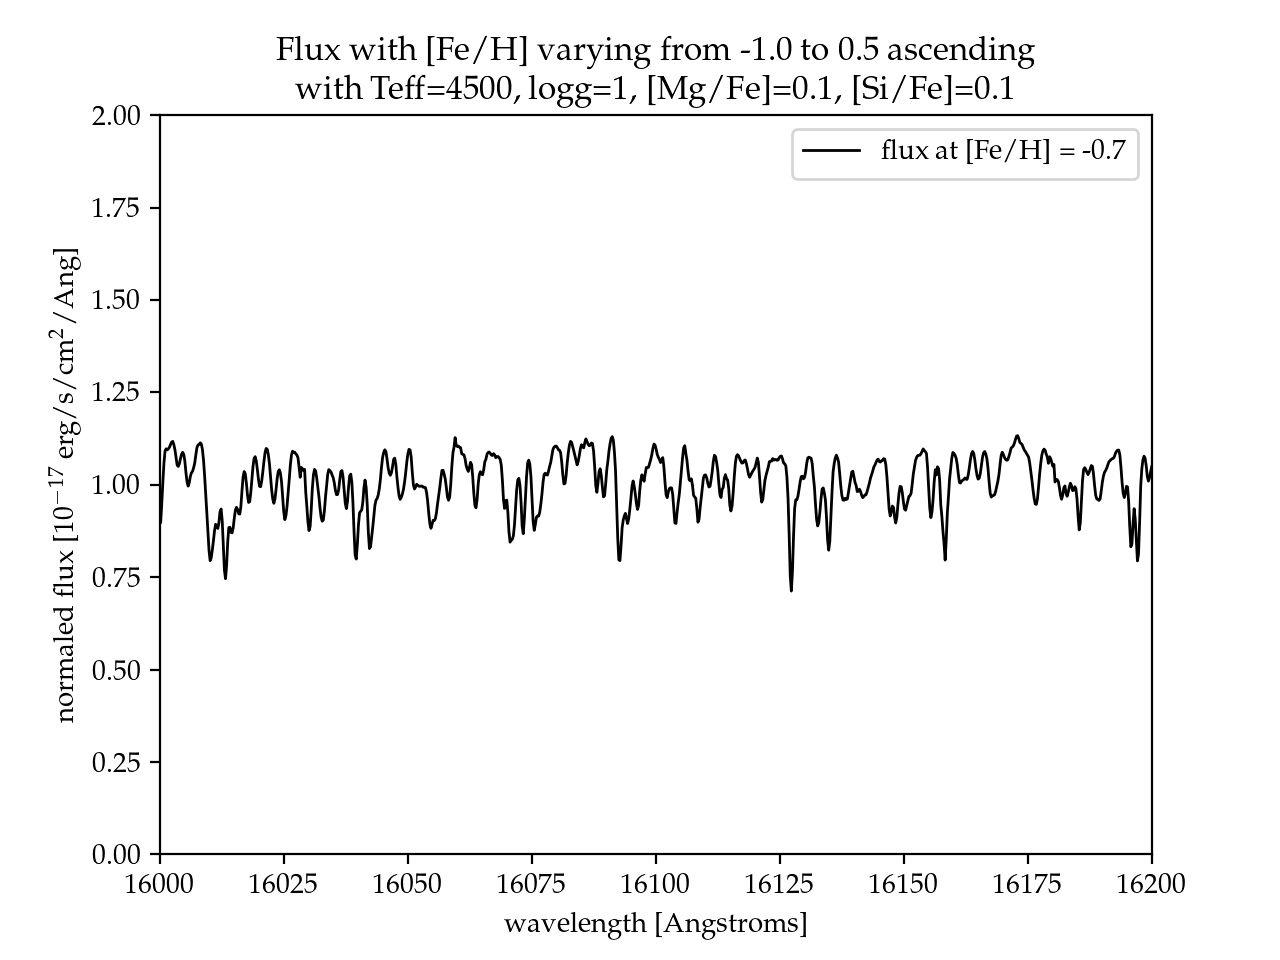

In [276]:
%matplotlib inline
%matplotlib notebook

fe_h = np.linspace(-1, 0.5, 100)
inds = np.where((labels_arr[index]['wavelength'] > 16000) & (labels_arr[index]['wavelength'] < 16200))
wl_rng = labels_arr[0]['wavelength'][inds]

fig = plt.figure()
ax = plt.axes(xlim=(16000, 16200), ylim=(0, 2))
ax.set_xlabel('wavelength [Angstroms]')
ax.set_ylabel('normaled flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_title('Flux with [Fe/H] varying from -1.0 to 0.5 ascending \nwith Teff=4500, logg=1, [Mg/Fe]=0.1, [Si/Fe]=0.1')
line, = ax.plot([], [], lw=1, color='k', label='[Fe/H]')

def init():
    line.set_data([], [])
    return line,
def animate(i):
    spec = np.array(model(np.array(theta_arr)[inds], 4500/5700, 1/4, fe_h[i], 0.1, 0.1))
    line.set_data(wl_rng, spec)
    feh = np.round(fe_h[i], decimals=2)
    line.set_label(f'flux at [Fe/H] = {feh}')
    plt.legend()
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=30) 

plt.show()

In [277]:
RGB_inds1 = np.where((logg < 3.5) & (logg > 0.5) & (teff > 3000) & (teff < 6000))[0][:110]
RGB_logg = logg[RGB_inds1]
RGB_teff = teff[RGB_inds1]

<IPython.core.display.Javascript object>


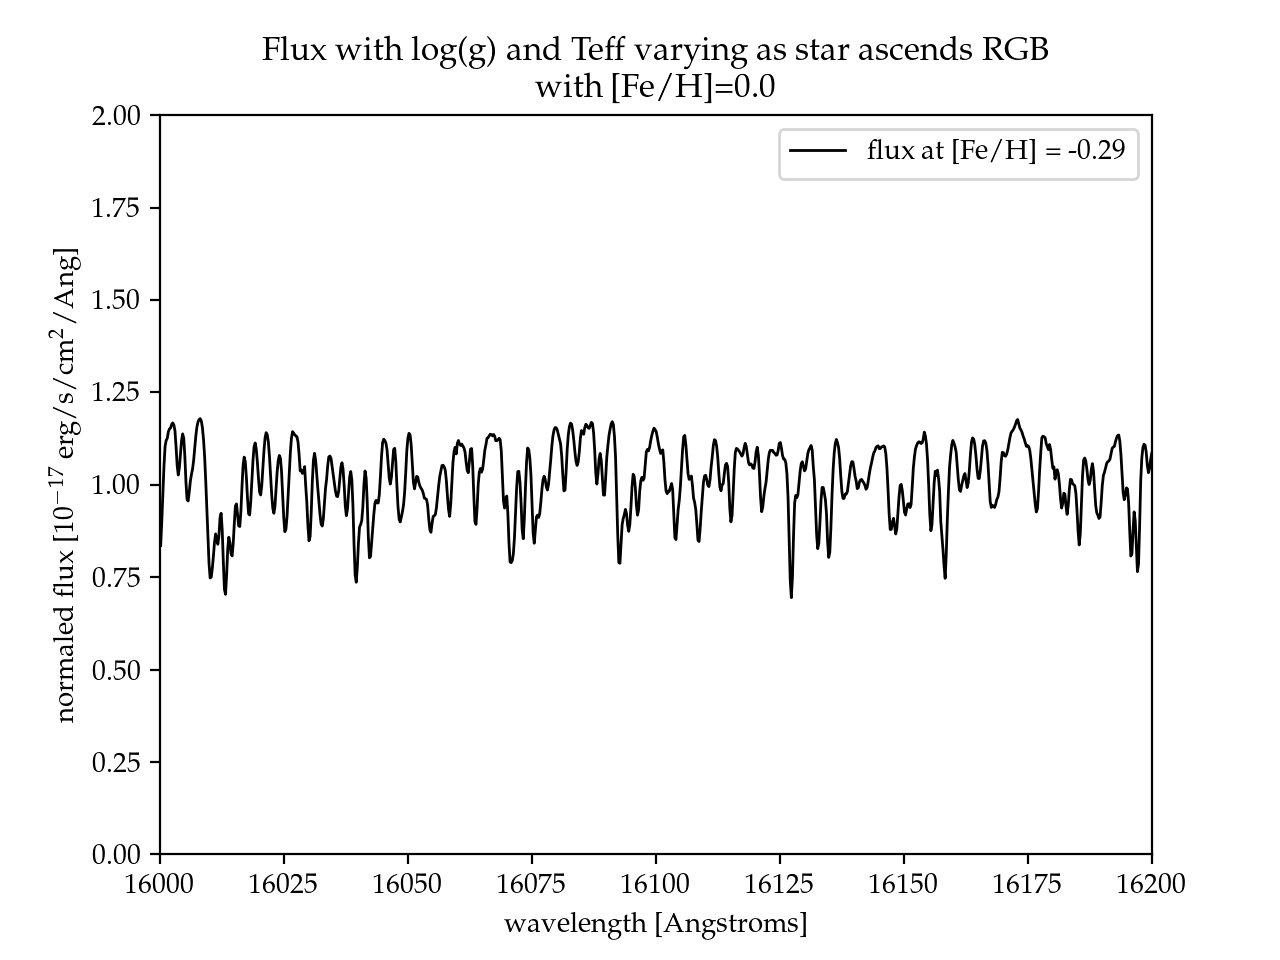

In [278]:
inds = np.where((labels_arr[index]['wavelength'] > 16000) & (labels_arr[index]['wavelength'] < 16200))
wl_rng = labels_arr[0]['wavelength'][inds]

fig = plt.figure()
ax = plt.axes(xlim=(16000, 16200), ylim=(0, 2))
ax.set_xlabel('wavelength [Angstroms]')
ax.set_ylabel('normaled flux [10$^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_title('Flux with log(g) and Teff varying as star ascends RGB \nwith [Fe/H]=0.0')
line, = ax.plot([], [], lw=1, color='k', label='[Fe/H]')

def init():
    line.set_data([], [])
    return line,
def animate(i):
    spec = np.array(model(np.array(theta_arr)[inds], RGB_teff[i]/5700, RGB_logg[i]/4, 0.0, 0.0, 0.0))
    line.set_data(wl_rng, spec)
    Teff = np.round(RGB_teff[i])
    Logg = np.round(RGB_logg[i], decimals=1)
    line.set_label(f'flux at Teff={Teff},\nlog(g)={Logg}')
    plt.legend()
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=30)  
plt.show()

# Complications not accounted for

One possible issue that we have not accounted for in our analysis is that some stars may be in binary systems. If these stars have small enough angular resolutions, then we will not be able to differentiate between the two when obtaining flux values. As a result, we will see not one but instead two spectra on top of each other.

This can completely skew the results. For example, if one of these stars is a white dwarf which has a higher metallicity than a giant star on average, then we will see a giant with a higher metallicity via absorption lines that we would normally see and this would then cause our model to learn improperly in the training step thus causing great errors in the validation step or we might not train on this binary system and later encounter it in the validation step which would break the model so to speak. Additionally, white dwarf stars have higher $\text{T}_{\text{eff}}$ and $\log{(\text{g})}$ values as well and so by the same reasoning as we posited before, the model would either have poor training inputs or it would not be able to accurately determine labels if it had not encountered such spectra in its training set. As a result of all of this, we would see positive biases in temperature, $\log{(\text{g})}$, and $\text{[Fe/H]}$. Since, for a given spectra we would expect it to have higher label values than it actually has due to the fact that the model would see a similar spectra from a binary system which has higher label values than an individual giant star.

We might correct for this issue by selecting stars which we know suffer less from binary star and specifically white dwarf contamination. Additionally, we could develop other tests to determine signatures of binary presence in a spectrum; these tests might involve generating a model which uses other labels such as rotation and other chemical abundances.